# Predicting developer salaries

This notebook explores the stack overflow developer survey data from 2020. The goal is to predict the salary of a developer based on the data provided in the survey. The data is available at https://insights.stackoverflow.com/survey I will also include the csv bundled with this project.

The survey is long, and there are many questions that are not relevant to our goal. I will only use the data that is relevant to our goal. I will also clean up the data, and transform it into a format that is suitable for machine learning algorithms. 60 columns are in the dataset, ranging from country and education to the technologies used to even more informal questions.

Such a task is hard, but I tried to look into all of the columns in order to see their usefulness. Without further ado, let us begin.

#### Importing the necessary libraries
The libraries that I imported are pretty standard. Of note is the xgboost library and the lightgbm library which provided me with some of the better machine learning models that I used during the training process. I also used the joblib library to save the models that I trained, so that I can use them later without having to retrain them.

In [ ]:
import numpy
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_validate,GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor,BaggingRegressor, RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm


#### Defining some useful methods
 This method used to shorten the categories of a categorical column
 When dealing with countries, it would be nice to be able to take them
 all into account, but there are too many of them. We can shorten the
 list by grouping all countries with less than a certain number of
 respondents into a single category called "Other", since we
 do actually want to use the country as a feature.

In [ ]:
def shorten_categories(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

This method used to split a column with multiple options into multiple columns
  useful for the languages which are listed as ; separated values. This is very useful because of the type of data in the csv, where the users had to select a multiple choice value and the ouput to us is a ";" delimited list. Using just this column would be a bad idea since we would get way too many features that are not really relevant.

In [ ]:
def split_multicolumn(col_series, prefix):
    result_df = col_series.to_frame()
    options = []
    # Iterate over the column
    for idx, value  in col_series[col_series.notnull()].items():
        # Break each value into list of options
        for option in value.split(';'):
            option = prefix + option
            # Add the option as a column to result
            if not option in result_df.columns:
                options.append(option)
                result_df[option] = 0.
            # Mark the value in the option column as True
            result_df.at[idx, option] = 1.
    return result_df[options]
# both of the methods above are courtesy of https://github.com/tien02, modified by me

#### Reading the data
The data is read from the local file. The first column is dropped as it's just an id similar to the one automatically assigned by pandas. The second column is the schema of the data, which is used to get the names of the columns. The schema is also used to get the description of each column, which is useful for understanding the data. \

The schema is also used to get the meaning of each column, which is useful for knowing what the question entailed. For example, the column "MainBranch" is the answer to the question "Which of the following options best describes you today? Here, by "developer" we mean "someone who writes code."". The column "Employment" is the answer to the question "Which of the following best describes your current employment status?". All of this information is available in the file of so_survery_2020.pdf, which is available at https://insights.stackoverflow.com/survey

In [ ]:
# the file is located in "datasets/so/survey_results_public.csv"
def read_data():
    df = pd.read_csv("datasets/so/survey_results_public.csv")
    df.drop(["Respondent"], axis=1, inplace=True)
    cols = pd.read_csv("datasets/so/survey_results_schema.csv")
    cols.set_index("Column", inplace=True)
    # drop as rows from cols
    cols.drop("Respondent",axis=0, inplace=True)
    return df, cols
(df, cols) = read_data()

## Exploring the data
We are greeted by 60 columns. Immediately we see that this survey also surveyed students and people that are not professional developers, as given by the "MainBranch" column. Some processing will have to be done

In [ ]:
df.head()

MainBranch Hobbyist   Age  \
0                     I am a developer by profession      Yes   NaN   
1                     I am a developer by profession       No   NaN   
2                        I code primarily as a hobby      Yes   NaN   
3                     I am a developer by profession      Yes  25.0   
4  I used to be a developer by profession, but no...      Yes  31.0   

  Age1stCode CompFreq  CompTotal  ConvertedComp             Country  \
0         13  Monthly        NaN            NaN             Germany   
1         19      NaN        NaN            NaN      United Kingdom   
2         15      NaN        NaN            NaN  Russian Federation   
3         18      NaN        NaN            NaN             Albania   
4         16      NaN        NaN            NaN       United States   

     CurrencyDesc CurrencySymbol  ...                  SurveyEase  \
0   European Euro            EUR  ...  Neither easy nor difficult   
1  Pound sterling            GBP  ...                         NaN   
2             NaN            NaN  ...  Neither easy nor difficult   
3    Albanian lek            ALL  ...                         NaN   
4             NaN            NaN  ...                        Easy   

            SurveyLength Trans  \
0  Appropriate in length    No   
1                    NaN   NaN   
2  Appropriate in length   NaN   
3                    NaN    No   
4              Too short    No   

                                      UndergradMajor WebframeDesireNextYear  \
0  Computer science, computer engineering, or sof...           ASP.NET Core   
1  Computer science, computer engineering, or sof...                    NaN   
2                                                NaN                    NaN   
3  Computer science, computer engineering, or sof...                    NaN   
4  Computer science, computer engineering, or sof...   Django;Ruby on Rails   

     WebframeWorkedWith                             WelcomeChange WorkWeekHrs  \
0  ASP.NET;ASP.NET Core   Just as welcome now as I felt last year        50.0   
1                   NaN  Somewhat more welcome now than last year         NaN   
2                   NaN  Somewhat more welcome now than last year         NaN   
3                   NaN  Somewhat less welcome now than last year        40.0   
4         Ruby on Rails   Just as welcome now as I felt last year         NaN   

  YearsCode YearsCodePro  
0        36           27  
1         7            4  
2         4          NaN  
3         7            4  
4        15            8  

[5 rows x 60 columns]

The number of rows in dataframe is around 60k, plenty enough for our purposes. However there are many null fields which will have tpo be dropped or filled in. Still, we have plenty of data to work with.

In [ ]:
df.shape

(64461, 60)

Only 4 rows are currently numbers, which is a big problem for us. We will have to transform the data into a format that is suitable for machine learning algorithms.

In [ ]:
df.describe()

Age      CompTotal  ConvertedComp   WorkWeekHrs
count  45446.000000   3.482600e+04   3.475600e+04  41151.000000
mean      30.834111  3.190464e+242   1.037561e+05     40.782174
std        9.585392            inf   2.268853e+05     17.816383
min        1.000000   0.000000e+00   0.000000e+00      1.000000
25%       24.000000   2.000000e+04   2.464800e+04     40.000000
50%       29.000000   6.300000e+04   5.404900e+04     40.000000
75%       35.000000   1.250000e+05   9.500000e+04     44.000000
max      279.000000  1.111111e+247   2.000000e+06    475.000000

In [ ]:
df.columns

Index(['MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq', 'CompTotal',
       'ConvertedComp', 'Country', 'CurrencyDesc', 'CurrencySymbol',
       'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel',
       'Employment', 'Ethnicity', 'Gender', 'JobFactors', 'JobSat', 'JobSeek',
       'LanguageDesireNextYear', 'LanguageWorkedWith',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith',
       'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch',
       'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms',
       'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites',
       'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear',
       'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount',
       'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength',
       'Trans', 'UndergradMajor', 'WebframeDesireNextYear',
       'Webframe

The meaning of each column can be seen below.

In [ ]:
cols

QuestionText
Column                                                                         
MainBranch                    Which of the following options best describes ...
Hobbyist                                                Do you code as a hobby?
Age                           What is your age (in years)? If you prefer not...
Age1stCode                    At what age did you write your first line of c...
CompFreq                       Is that compensation weekly, monthly, or yearly?
CompTotal                     What is your current total compensation (salar...
ConvertedComp                 Salary converted to annual USD salaries using ...
Country                                                      Where do you live?
CurrencyDesc                  Which currency do you use day-to-day? If your ...
CurrencySymbol                Which currency do you use day-to-day? If your ...
DatabaseDesireNextYear        Which database environments have you done exte...
DatabaseWorkedWith            Which database environments have you done exte...
DevType                       Which of the following describe you? Please se...
EdLevel                       Which of the following best describes the high...
Employment                    Which of the following best describes your cur...
Ethnicity                     Which of the following describe you, if any? P...
Gender                        Which of the following describe you, if any? P...
JobFactors                    Imagine that you are deciding between two job ...
JobSat                        How satisfied are you with your current job? (...
JobSeek                       Which of the following best describes your cur...
LanguageDesireNextYear        Which programming, scripting, and markup langu...
LanguageWorkedWith            Which programming, scripting, and markup langu...
MiscTechDesireNextYear        Which other frameworks, libraries, and tools h...
MiscTechWorkedWith            Which other frameworks, libraries, and tools h...
NEWCollabToolsDesireNextYear  Which collaboration tools have you done extens...
NEWCollabToolsWorkedWith      Which collaboration tools have you done extens...
NEWDevOps                     Does your company have a dedicated DevOps person?
NEWDevOpsImpt                 How important is the practice of DevOps to sca...
NEWEdImpt                     How important is a formal education, such as a...
NEWJobHunt                    In general, what drives you to look for a new ...
NEWJobHuntResearch            When job searching, how do you learn more abou...
NEWLearn                      How frequently do you learn a new language or ...
NEWOffTopic                   Do you think Stack Overflow should relax restr...
NEWOnboardGood                Do you think your company has a good onboardin...
NEWOtherComms                 Are you a member of any other online developer...
NEWOvertime                   How often do you work overtime or beyond the f...
NEWPurchaseResearch           When buying a new tool or software, how do you...
NEWPurpleLink                 You search for a coding solution online and th...
NEWSOSites                    Which of the following Stack Overflow sites ha...
NEWStuck                      What do you do when you get stuck on a problem...
OpSys                         What is the primary operating system in which ...
OrgSize                       Approximately how many people are employed by ...
PlatformDesireNextYear        Which platforms have you done extensive develo...
PlatformWorkedWith            Which platforms have you done extensive develo...
PurchaseWhat                  What level of influence do you, personally, ha...
Sexuality                     Which of the following describe you, if any? P...
SOAccount                                 Do you have a Stack Overflow account?
SOComm                        Do you consider yourself a member of the Stack...
SOPartFreq                    How frequently would you say you part

## Data cleaning and preprocessing
We will select only developers, we are not interested in other people.

In [ ]:
df = df[df["MainBranch"] == "I am a developer by profession"]
# drop the column "MainBranch" since it is no longer needed because it has the same value for all rows
df.drop(["MainBranch"], axis=1, inplace=True)
cols.drop("MainBranch", axis=0, inplace=True)
# We end up with around 47k rows, which is still plenty
df.shape

(47193, 59)

We only care about currently employed responders (as only those can gives us the salary), so the rest are dropped.

In [ ]:
# get all different responses for the column "Employment"
df["Employment"].unique()

array(['Independent contractor, freelancer, or self-employed',
       'Employed full-time', nan, 'Not employed, but looking for work',
       'Student', 'Employed part-time', 'Retired',
       'Not employed, and not looking for work'], dtype=object)

In [ ]:
# select only developers who are employed full-time, part-time, as independent contractors or as students
df= df[df["Employment"].isin(["Employed full-time",
                "Independent contractor, freelancer, or self-employed",
                              "Employed part-time",
                              "Student"])]
df.shape

(45867, 59)

We have lost some data, but at over 45k we are still well above the minimum required for our purposes.

In [ ]:
df.head()

Hobbyist   Age Age1stCode CompFreq  CompTotal  ConvertedComp  \
0      Yes   NaN         13  Monthly        NaN            NaN   
1       No   NaN         19      NaN        NaN            NaN   
5       No   NaN         14      NaN        NaN            NaN   
6      Yes   NaN         18  Monthly        NaN            NaN   
7      Yes  36.0         12   Yearly   116000.0       116000.0   

          Country          CurrencyDesc CurrencySymbol DatabaseDesireNextYear  \
0         Germany         European Euro            EUR   Microsoft SQL Server   
1  United Kingdom        Pound sterling            GBP                    NaN   
5         Germany         European Euro            EUR                    NaN   
6           India  United States dollar            USD                    NaN   
7   United States  United States dollar            USD                MongoDB   

   ...                  SurveyEase           SurveyLength Trans  \
0  ...  Neither easy nor difficult  Appropriate in length    No   
1  ...                         NaN                    NaN   NaN   
5  ...  Neither easy nor difficult  Appropriate in length   NaN   
6  ...                         NaN                    NaN   NaN   
7  ...                        Easy  Appropriate in length    No   

                                      UndergradMajor  WebframeDesireNextYear  \
0  Computer science, computer engineering, or sof...            ASP.NET Core   
1  Computer science, computer engineering, or sof...                     NaN   
5                                                NaN                React.js   
6  Computer science, computer engineering, or sof...                     NaN   
7  Computer science, computer engineering, or sof...  Django;React.js;Vue.js   

     WebframeWorkedWith                             WelcomeChange WorkWeekHrs  \
0  ASP.NET;ASP.NET Core   Just as welcome now as I felt last year        50.0   
1                   NaN  Somewhat more welcome now than last year         NaN   
5                   NaN                                       NaN         NaN   
6                   NaN     A lot more welcome now than last year         NaN   
7                 Flask   Just as welcome now as I felt last year        39.0   

  YearsCode YearsCodePro  
0        36           27  
1         7            4  
5         6            4  
6         6            4  
7        17           13  

[5 rows x 59 columns]

The column we are interested in is "ConvertedComp", as given by the schema: "Salary converted to annual USD salaries using the exchange rate on 2020-02-19, assuming 12 working months and 50 working weeks." We will rename it to "Salary" for simplicity, and remove everyone that did not provide a salary, as we cannot use them.

In [ ]:
# rename "ConvertedComp" to "Salary"
df.rename(columns={"ConvertedComp": "Salary"}, inplace=True)
cols.replace({"ConvertedComp": "Salary"}, inplace=True)
# drop all rows where salary is missing. No useful information can be extracted if no salary has been provided
df.dropna(subset=["Salary"], inplace=True)

In what follows, some first steps are taken to clean the data. The data is cleaned in the following ways:
- The "Hobbyist" column is converted to a boolean column (but using numbers instead of True/False)
- The "Age1stCode" column is converted to float, and the values "Younger than 5 years" and "Older than 85" are replaced with 4 and 86 respectively. While this is not an exact representation, it is close enough for our purposes., because people who started coding before 5 years old or after 85 years old are very rare.
- The "YearsCodePro" column is converted to float, and the values "Less than 1 year" and "More than 50 years" are replaced with 0.5 and 51 respectively. Now people coding professionally for less than 1 year will definitely have smaller salaries, so I assigned a small value (0.5) to it.

In [ ]:
# replace hobbyist column with True and False instead of "Yes" and "No"
df["Hobbyist"] = df["Hobbyist"].map({"Yes": 1, "No": 0})
# drop age1stCode column since it is not needed
# to be cast age1stCode to float
df["Age1stCode"].replace({"Younger than 5 years": 4,
                          "Older than 85": 86}, inplace=True)
df["Age1stCode"] = df["Age1stCode"].astype(float)

# clean up years coding as a pro
df["YearsCodePro"].replace({"Less than 1 year": 0.5, "More than 50 years" : 51}, inplace=True)
df["YearsCodePro"] = df["YearsCodePro"].astype(float)

Map work week hours to max number of 70, assume that people who work more than 70 hours per week
work 71 hours per week, mask for more than 70. This may seem weird, but some visualization that did not make it into the final version of this notebook showed that there were many weird values like over 200, so a cap is necessary because of the way people filled in the survey.

In [ ]:
mask = df["WorkWeekHrs"] > 70
# set all values in the mask to 71
df.loc[mask, "WorkWeekHrs"] = 71

In what follows, many irrelevant columns are dropped from both the main dataframe and the columns dataframe. The dropped columns are multiple. I decided to drop yearsCode as it should have the same info as yearsCodePro, just with the difference that this one includes education.

Desires were also not taken into account. While some useful information might have been extracted, the dataset is already large enough and the processing monumental, so they are left to be explored at a later date, same thing for the Stack-Overflow related columns.

In [ ]:
# drop "CompTotal" and "CompFreq", "CurrencyDesc", "CurrencySymbol" columns
# since they no longer provide anymore useful information
df.drop(["CompTotal", "CompFreq", "CurrencyDesc", "CurrencySymbol"], axis=1, inplace=True)
cols.drop(["CompTotal", "CompFreq", "CurrencyDesc", "CurrencySymbol"], axis=0, inplace=True)
# drop the other redundant one that duplicates information
df.drop(["YearsCode"], axis=1, inplace=True)
cols.drop(["YearsCode"], axis=0, inplace=True)
# drop desires and job hunting prospects since they cannot become numbered data for regression
df.drop(["DatabaseDesireNextYear", "LanguageDesireNextYear", "MiscTechDesireNextYear", "NEWCollabToolsDesireNextYear",
        "NEWJobHunt", "NEWJobHuntResearch","NEWOffTopic","Trans", "WebframeDesireNextYear", "Sexuality","NEWPurchaseResearch","PlatformDesireNextYear"], axis=1, inplace=True)
cols.drop(["DatabaseDesireNextYear", "LanguageDesireNextYear", "MiscTechDesireNextYear",
           "NEWCollabToolsDesireNextYear", "Trans","NEWJobHunt","NEWJobHuntResearch","NEWOffTopic", "WebframeDesireNextYear", "Sexuality","NEWPurchaseResearch","PlatformDesireNextYear"], axis=0, inplace=True)
df.drop(["Ethnicity","Gender"], axis=1, inplace=True)
cols.drop(["Ethnicity","Gender"], axis=0, inplace=True)
# drop data about the survey
df.drop(["SurveyEase", "SurveyLength", "WelcomeChange","NEWOtherComms",
         "NEWPurpleLink","NEWSOSites","NEWStuck"], axis=1, inplace=True)
cols.drop(["SurveyEase", "SurveyLength", "WelcomeChange","NEWOtherComms",
           "NEWPurpleLink","NEWSOSites","NEWStuck"], axis=0, inplace=True)
# drop stackoverflow related data, while it might be interesting, it is not relevant for the regression
# Useful data might be extracted from them, but time is of the essence so I shall leave them for another time
# SOAccount, SOComm, SOPartFreq, SOVisitFreq
df.drop(["SOAccount", "SOComm", "SOPartFreq", "SOVisitFreq"], axis=1, inplace=True)
cols.drop(["SOAccount", "SOComm", "SOPartFreq", "SOVisitFreq"], axis=0, inplace=True)

In [ ]:
# around 30k rows are left
df.shape

(31550, 29)

In [ ]:
df.head(50)

Hobbyist   Age  Age1stCode     Salary         Country  \
7           1  36.0        12.0   116000.0   United States   
9           1  22.0        14.0    32315.0  United Kingdom   
10          1  23.0        13.0    40070.0  United Kingdom   
11          0  49.0        42.0    14268.0           Spain   
13          1  27.0        13.0    66000.0   United States   
15          1  45.0         8.0   108576.0  United Kingdom   
16          1  25.0        14.0    79000.0   United States   
17          1  32.0        12.0  1260000.0   United States   
18          0  24.0        15.0    83400.0   United States   
23          1  45.0        14.0    91883.0         Germany   
25          0   NaN        12.0    71093.0          Canada   
29          1   NaN        14.0    38778.0  United Kingdom   
31          1  31.0        12.0    31764.0          Canada   
32          1  39.0        14.0    63564.0         Belgium   
37          0  35.0        14.0    97288.0           Italy   
40          0   NaN        15.0   106000.0   United States   
41          0  32.0        14.0   130000.0   United States   
42          1   NaN        16.0   135000.0   United States   
43          0  32.0        21.0    55893.0          Brazil   
44          1  22.0        13.0    36753.0          France   
45          1  24.0        14.0    37834.0          France   
46          1  53.0        10.0    74970.0  United Kingdom   
47          0  38.0        30.0   125000.0   United States   
48          0  23.0        15.0    52000.0   United States   
50          0   NaN        10.0   103615.0          Canada   
51          0  28.0        15.0    90482.0  United Kingdom   
53          0  44.0         7.0   160000.0   United States   
56          0  44.0        12.0  1620000.0   United States   
58          0  38.0        15.0    16488.0          Brazil   
63          1  34.0        12.0    94359.0  United Kingdom   
64          1  34.0        13.0  1176000.0   United States   
66          1  35.0         6.0   250000.0   United States   
68          1  25.0        12.0   594539.0          France   
69          1  25.0        19.0    23913.0  United Kingdom   
73          1  34.0         8.0   124092.0  United Kingdom   
78          0  28.0        17.0    37816.0          Canada   
79          1  32.0        11.0    94500.0   United States   
81          1  48.0        11.0   117000.0   United States   
82          1  20.0        17.0     3036.0          Poland   
85          1  26.0        10.0   108100.0          France   
88          1  28.0        12.0   130000.0   United States   
89          1  28.0        25.0    61476.0       Indonesia   
90          1  31.0        11.0    57292.0          France   
93          1   NaN        12.0    71850.0          Canada   
94          1  29.0        21.0    35028.0          Israel   
95          1  30.0        13.0    75631.0          Canada   
96          0  29.0        15.0    41568.0  Czech Republic   
97          1  30.0         7.0    79413.0          Canada   
98          1  42.0         8.0    93000.0   United States   
103         1  28.0        16.0    40000.0   United States   

                                    DatabaseWorkedWith  \
7                                  MariaDB;MySQL;Redis   
9                                 Microsoft SQL Server   
10                  Firebase;MongoDB;PostgreSQL;SQLite   
11                                                 NaN   
13                       Firebase;Microsoft SQL Server   
15                                          PostgreSQL   
16                     Microsoft SQL Server;PostgreSQL   
17            Elasticsearch;MariaDB;MySQL;Redis;SQLite   
18                        MariaDB;Microsoft SQL Server   
23                                   PostgreSQL;SQLite   
25                                          PostgreSQL   
29                   Microsoft SQL Server;Redis;SQLite   
31                                        MySQL;SQLite   
32                     MongoDB

### Preliminary data visualization
The first thing to do is look at how our data is split into histogram bins.

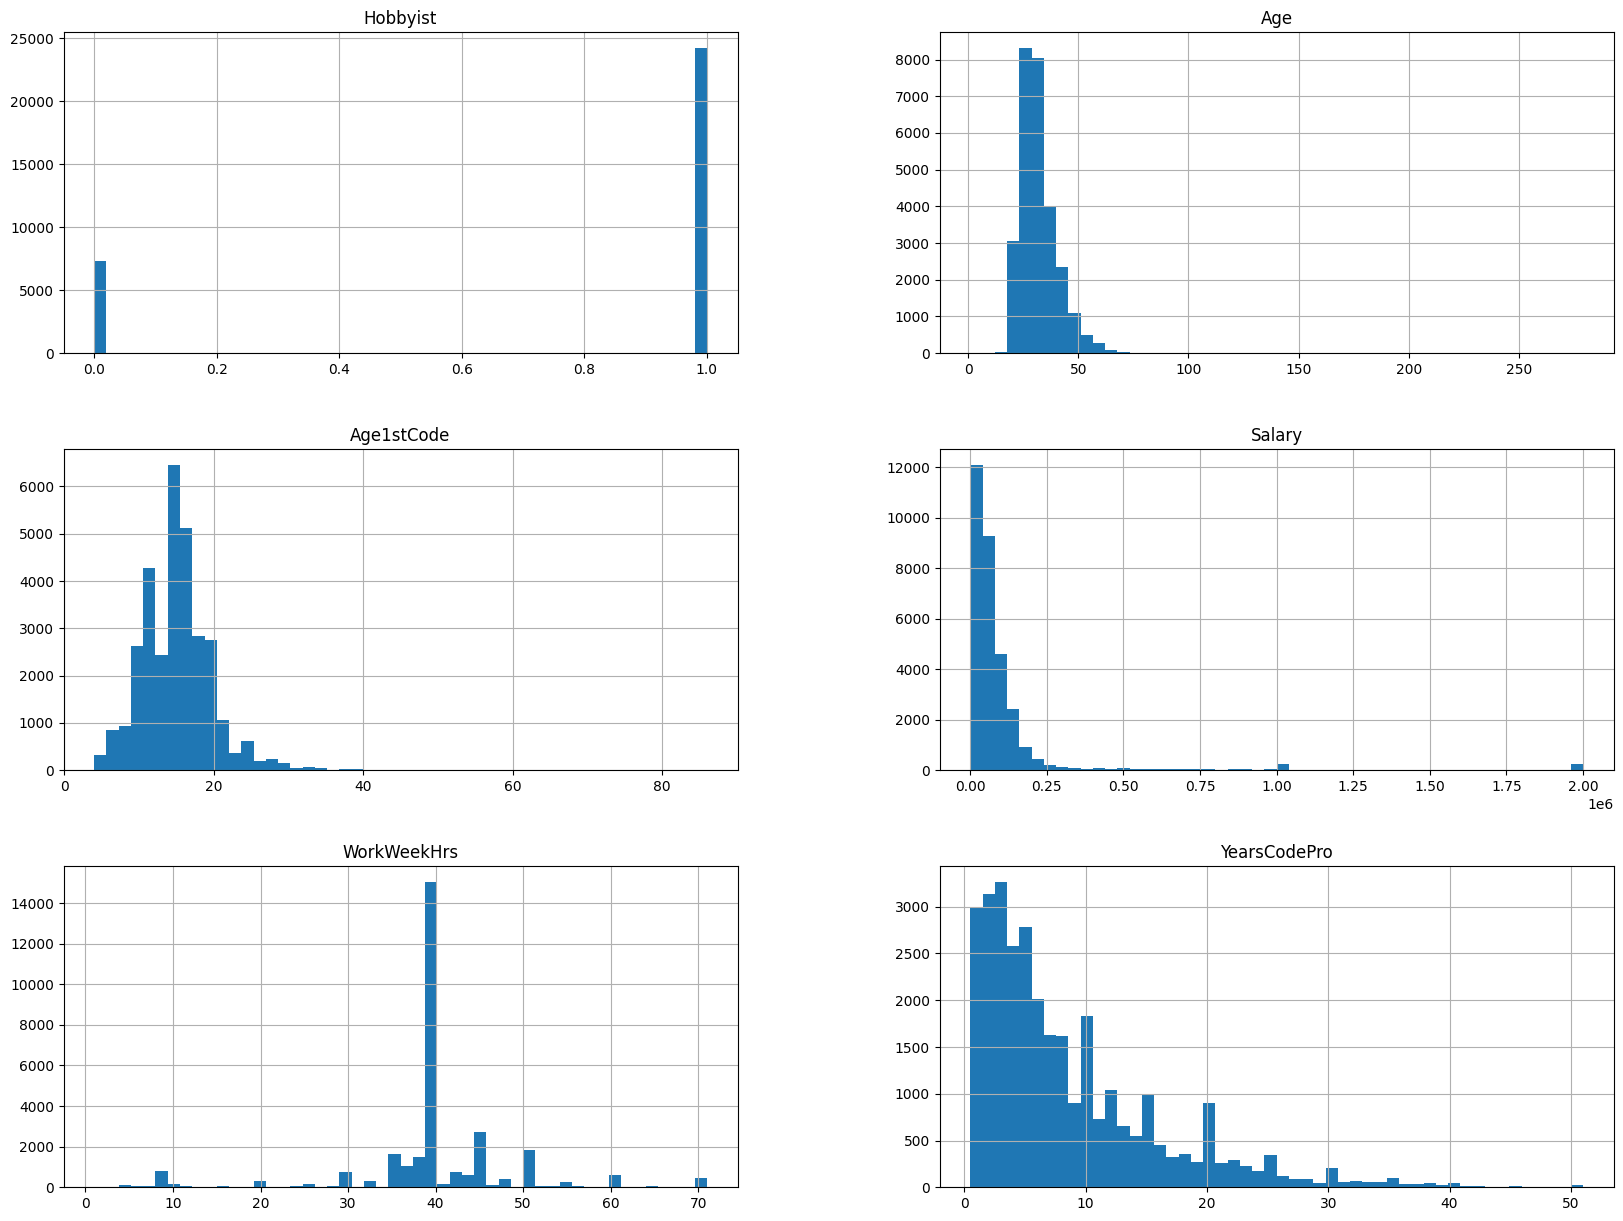

In [ ]:
df.hist(bins =50, figsize=(20,15))
plt.show()

#### Salary preprocessing

As seen above, the salary has some outliers at 2 million, because data was capped at 2 million in the survey.
All salaries above the cut-off will be considered outliers and be removed. While a model shouldn't really limit the data like this, we have very few datapoints of really large values, and keeping them means that the model will be guessing way too much and making big errors, which might affect even the smaller salary. Still, a cut-off of 300k is chosen, since it is a (perhaps too) reasonable salary for a senior developer in the US.

<AxesSubplot:>

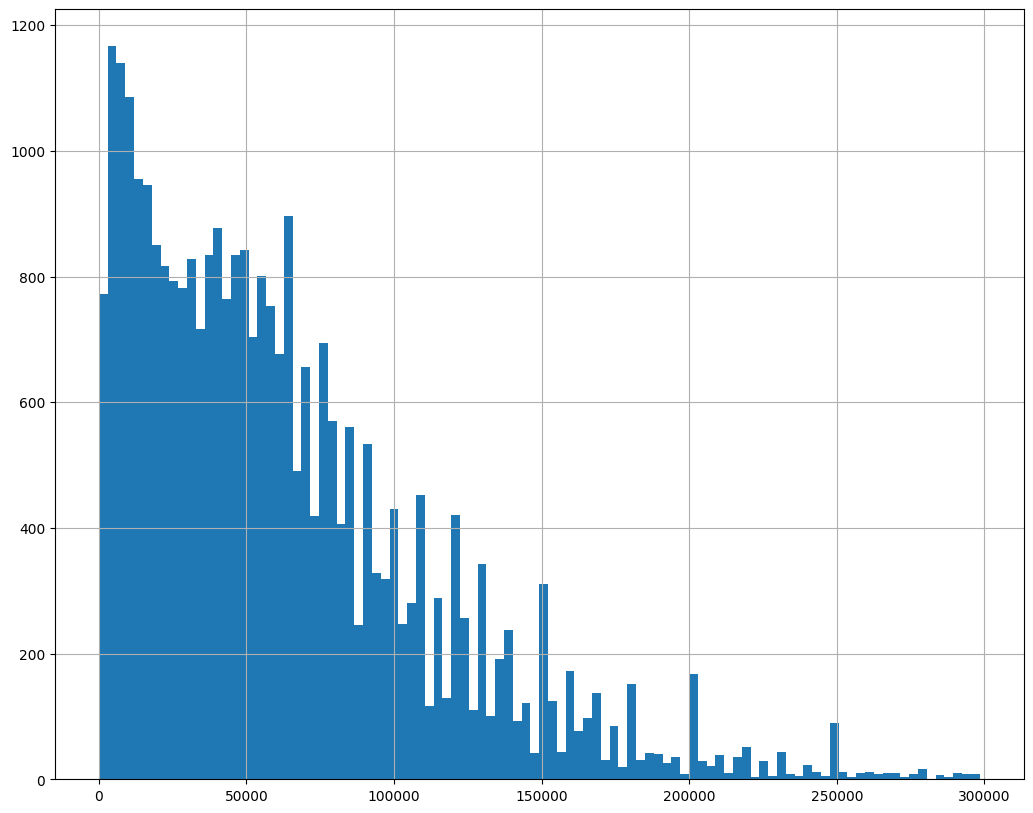

In [ ]:
max_salary = 300000

mask = df["Salary"] >= max_salary
# drop all rows with salaries above max_salary
df.drop(df[mask].index, inplace=True)
df["Salary"].hist(bins=100, figsize=(12.5,10))

Age will be capped at 80, since there are very few entries above 80, and many of those people claim to be over 200 years old, which is obviously not true. There is some discussion about the validity of the data in this survey, many people might have completed it as a joke, so it is important to keep this in mind when looking at the possibly poor results of the regression.

<AxesSubplot:>

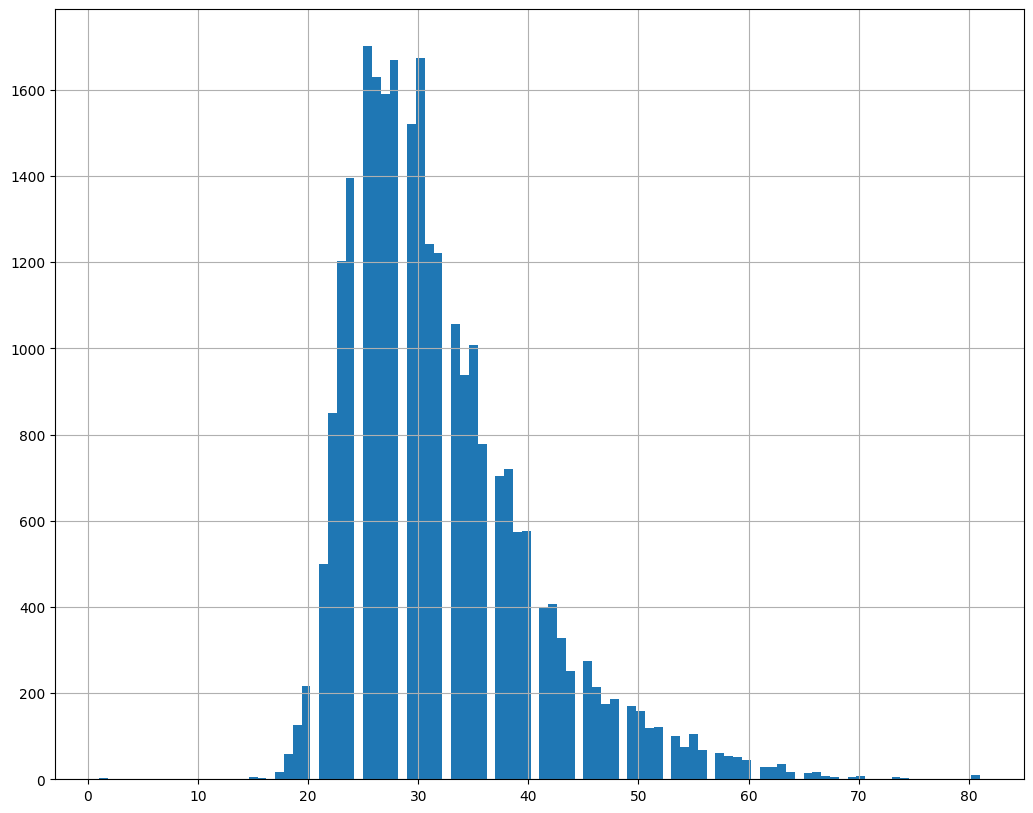

In [ ]:
# mask for ages above 80
mask = df["Age"] >= 80
# all rows with age above 80 will be changed to 81
df.loc[mask, "Age"] = 81
df["Age"].hist(bins=100, figsize=(12.5,10))

age1st code has some outlier data, will cap to 50

<AxesSubplot:>

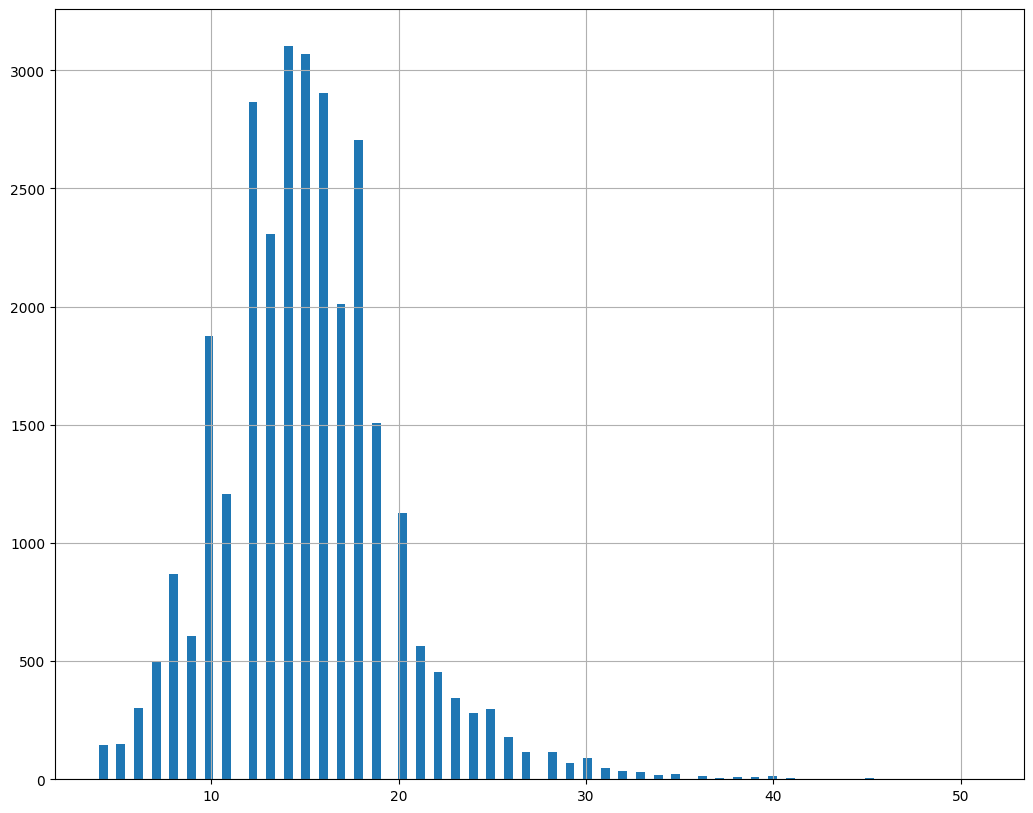

In [ ]:
# mask for ages above 50
mask = df["Age1stCode"] >= 50
# all rows with age above 50 will be changed to 51
df.loc[mask, "Age1stCode"] = 51
df["Age1stCode"].hist(bins=100, figsize=(12.5,10))

Will rename the education levels column to something shorter and easier to work with, and easier to plot. As we can see, most developers have some formal education, while only a minority have only high school or less.

<AxesSubplot:>

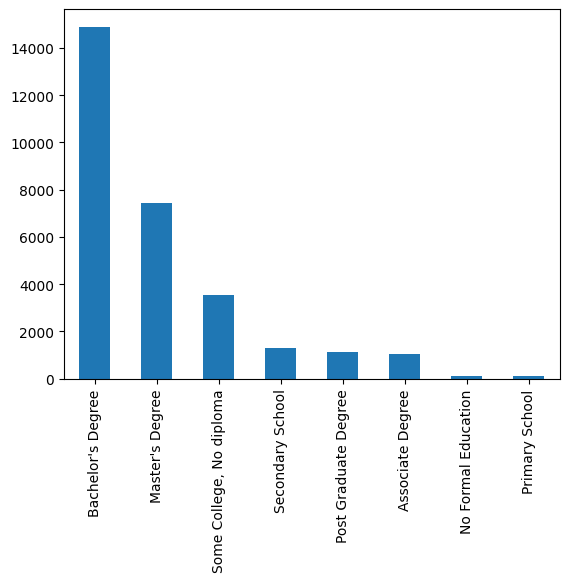

In [ ]:
df["EdLevel"].replace({"Bachelor’s degree (B.A., B.S., B.Eng., etc.)": "Bachelor's Degree",
                       "Master’s degree (M.A., M.S., M.Eng., MBA, etc.)": "Master's Degree",
                       "Some college/university study without earning a degree": "Some College, No diploma",
                       "Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)": "Secondary School",
                       "Associate degree (A.A., A.S., etc.)": "Associate Degree",
                       "Other doctoral degree (Ph.D., Ed.D., etc.)": "Post Graduate Degree",
                       "Professional degree (JD, MD, etc.)": "Post Graduate Degree",
                       "Primary/elementary school": "Primary School",
                       "I never completed any formal education": "No Formal Education",
                       "I prefer not to answer": "No answer"}, inplace=True)
# plot number of entries by "EdLevel"
df["EdLevel"].value_counts().plot(kind="bar")

Rename the overtime column to something shorter and easier to work with, and easier to plot. As we can see, most developers work overtime at least sometimes.

<AxesSubplot:>

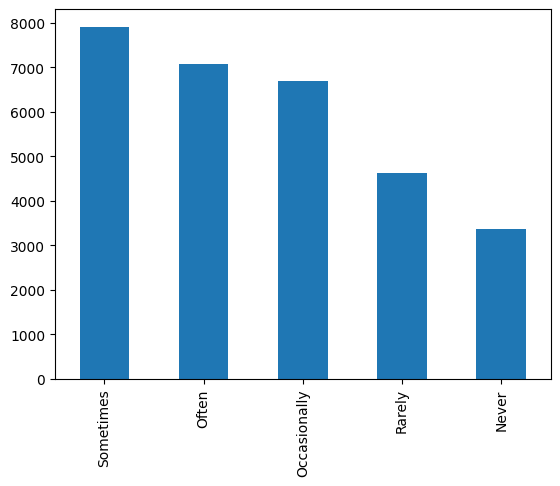

In [ ]:
df["NEWOvertime"].replace({"Often: 1-2 days per week or more": "Often",
                           "Sometimes: 1-2 days per month but less than weekly": "Sometimes",
                           "Occasionally: 1-2 days per quarter but less than monthly": "Occasionally",
                           "Rarely: 1-2 days per year or less": "Rarely",
                           "Never: 0 days per week": "Never"}, inplace=True)
df["NEWOvertime"].value_counts().plot(kind="bar")

#### Exploring job satisfaction
Job satisfaction has a great possibility of being correlated with salary, so it is important to explore it. I will plot the median salary for each job satisfaction category, and then I will keep only the "Very satisfied" category, since it is the only one with a clear correlation with salary.

In [ ]:
# plot job satisfaction
df["JobSat"].value_counts().plot(kind="bar")

<AxesSubplot:>

In [ ]:
# plot median salary by job satisfaction
df.groupby(["JobSat"])["Salary"].median().sort_values(ascending=False).plot(kind="bar")

<AxesSubplot:xlabel='JobSat'>

In [ ]:
# Only the "Very satisfied"
# category will be kept, so the collumn job sat will have 1.0 for "Very satisfied" and 0.0 for all other categories
df["JobSat"].replace({"Very satisfied": 1.0,
                      "Slightly satisfied": 0.0,
                      "Neither satisfied nor dissatisfied": 0.0,
                      "Slightly dissatisfied": 0.0,
                      "Very dissatisfied": 0.0}, inplace=True)
df["JobSat"] = df["JobSat"].astype("float")

#### Exploring org size
Same process applied for org size, larger organizations and freelancers might make more money.

In [ ]:
# plot org size
df["OrgSize"].value_counts().plot(kind="bar")

<AxesSubplot:>

In [ ]:
# plot median salary by org size
df.groupby(["OrgSize"])["Salary"].median().sort_values(ascending=False).plot(kind="bar")

<AxesSubplot:xlabel='OrgSize'>

Similar to above, only "OrgSize" of 10k or more employees becomes 1 and the rest 0, because only that one has a clear correlation to salary.

In [ ]:
df["OrgSize"].replace({"10,000 or more employees": 1.0,
                       "5,000 to 9,999 employees": 0.0,
                       "1,000 to 4,999 employees": 0.0,
                       "500 to 999 employees": 0.0,
                       "100 to 499 employees": 0.0,
                       "20 to 99 employees": 0.0,
                       "10 to 19 employees": 0.0,
                       "2 to 9 employees": 0.0,
                       "Just me - I am a freelancer, sole proprietor, etc.": 0.0}, inplace=True)
df["OrgSize"] = df["OrgSize"].astype("float")
df.shape

(30057, 29)

In [ ]:
df["JobSeek"].value_counts()

I’m not actively looking, but I am open to new opportunities    17417
I am not interested in new job opportunities                     8043
I am actively looking for a job                                  3773
Name: JobSeek, dtype: int64

<AxesSubplot:xlabel='JobSeek'>

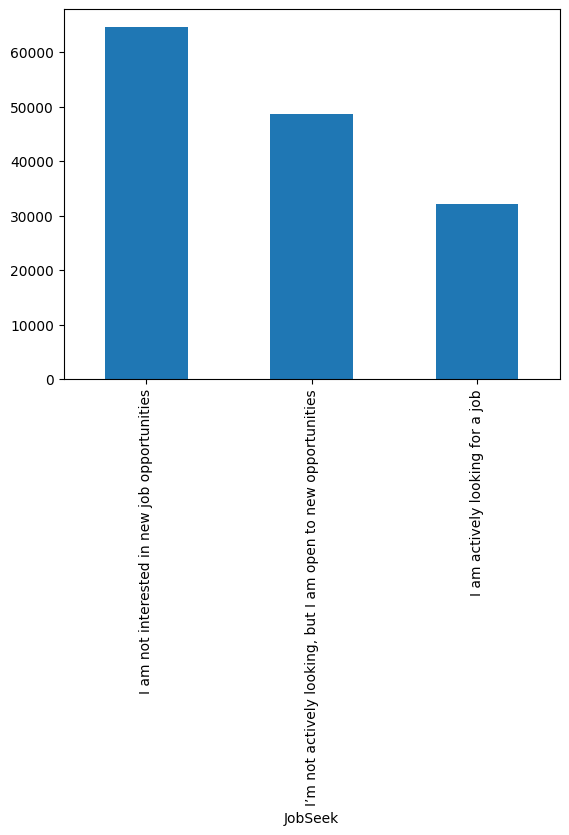

In [ ]:
# plot median salary by job seeking
df.groupby(["JobSeek"])["Salary"].median().sort_values(ascending=False).plot(kind="bar")

In [ ]:
# map the values of JobSeek to numerical values
df["JobSeek"].replace({"I am actively looking for a job": 1,
                       "I’m not actively looking, but I am open to new opportunities": 2,
                       "I am not interested in new job opportunities": 3}, inplace=True)
df["JobSeek"] = df["JobSeek"].astype("float")

#### Exploring overtime and salary
Overtime was explored, but unfortunately it did not improve the model at all. It is still interesting to see the visualization of the median salary by overtime.

In [ ]:
df["NEWOvertime"].value_counts()

Sometimes       7916
Often           7079
Occasionally    6705
Rarely          4632
Never           3360
Name: NEWOvertime, dtype: int64

<AxesSubplot:xlabel='NEWOvertime'>

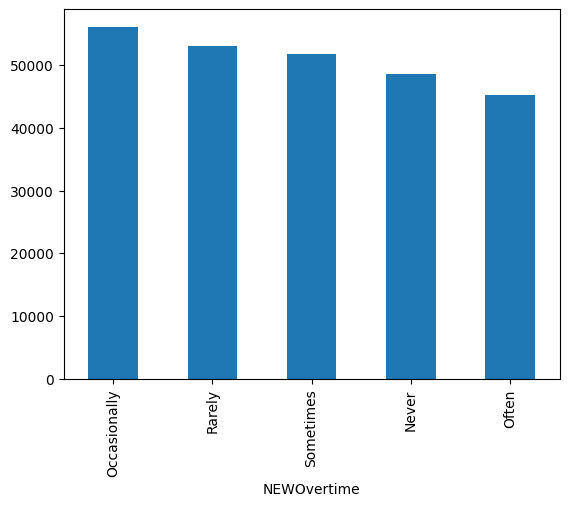

In [ ]:
# plot NEWOvertime by median salary
df.groupby(["NEWOvertime"])["Salary"].median().sort_values(ascending=False).plot(kind="bar")

#### Exploring new learn and salary
The desire of learning a new language definitely has the possibility of improving our model

In [ ]:
df["NEWLearn"].value_counts()

Once a year             11143
Every few months         9560
Once every few years     7221
Once a decade             516
Name: NEWLearn, dtype: int64

In [ ]:
# merge "Once every few years" and "Once a decade " into "Very rarely"
df["NEWLearn"].replace({"Once every few years": "Very rarely",
                        "Once a decade": "Very rarely"}, inplace=True)

In [ ]:
df["NEWLearn"].value_counts()

Once a year         11143
Every few months     9560
Very rarely          7737
Name: NEWLearn, dtype: int64

#### New learned langauges observations
 Despite the feature of new learn looking pretty good (after all programmers with large salaries aren't learning so many new things), it did not improve MSE or MAE scores at all.

<AxesSubplot:xlabel='NEWLearn'>

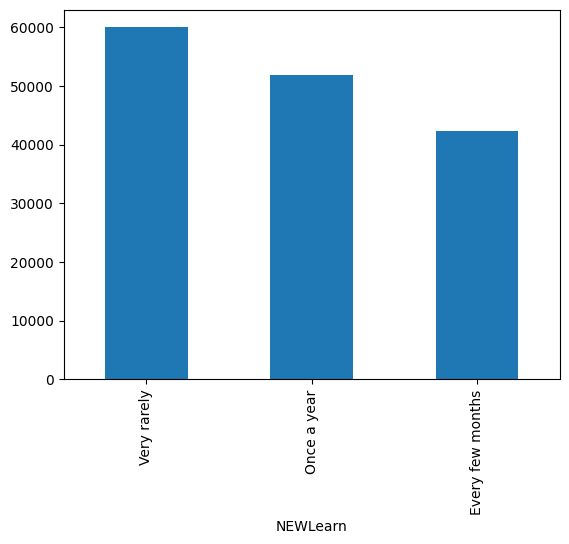

In [ ]:
# plot NEWLearn by median salary
df.groupby(["NEWLearn"])["Salary"].median().sort_values(ascending=False).plot(kind="bar")

#### Exploring involvement in purchasing decisions
The involvement in purchasing decisions is a very interesting feature, since it is very likely that people who are involved in purchasing decisions are managers or have a higher position in the company, and therefore make more money.

In [ ]:
# PurchaseWhat
df["PurchaseWhat"].value_counts()

I have little or no influence       11482
I have some influence               10208
I have a great deal of influence     4504
Name: PurchaseWhat, dtype: int64

<AxesSubplot:xlabel='PurchaseWhat'>

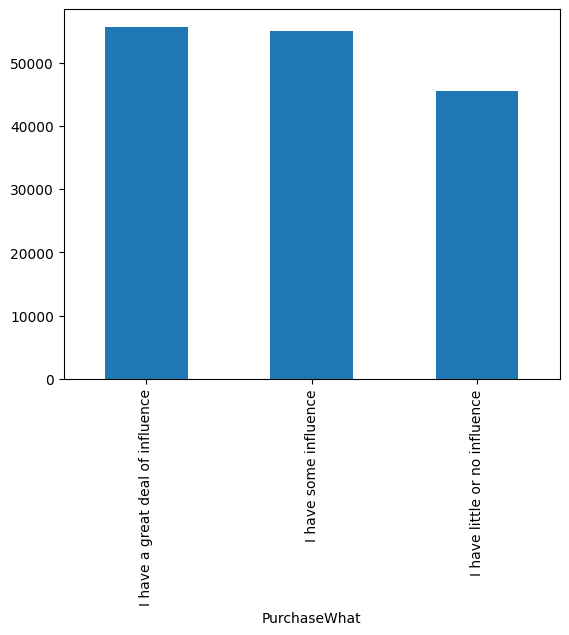

In [ ]:
# plot PurchaseWhat by median salary
df.groupby(["PurchaseWhat"])["Salary"].median().sort_values(ascending=False).plot(kind="bar")

This feature turned out to be a winning feature, improving r2 score by as much as 0.03.

In [ ]:
# map the values of PurchaseWhat to numerical values where 0 is "I have little or no influence" and 1 is "I have a great deal of influence" or "I have some influence"
df["PurchaseWhat"].replace({"I have little or no influence": 0,
                            "I have a great deal of influence": 1,
                            "I have some influence": 1}, inplace=True)
df["PurchaseWhat"] = df["PurchaseWhat"].astype("float")

#### Exploring New Devops
Despite the seemingly clear correlation, including this feature only introduced noise and did not improve the model. The question asked in the survey was: "Does your company have a dedicated DevOps person?". The answers were "Yes", "No" and "Not sure". I mapped the values to 0, 1 and 2 respectively.

In [ ]:
# NEWDevOps
df["NEWDevOps"].value_counts()

No          13116
Yes         13045
Not sure     3345
Name: NEWDevOps, dtype: int64

<AxesSubplot:xlabel='NEWDevOps'>

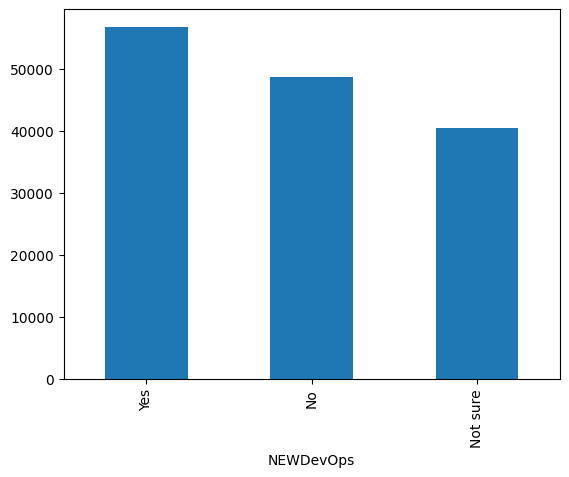

In [ ]:
# plot NEWDevOps by median salary
df.groupby(["NEWDevOps"])["Salary"].median().sort_values(ascending=False).plot(kind="bar")

In [ ]:
# map the values of NEWDevOps to numerical values where 0 is "Not Sure", 1 is "No" and 2 is "Yes"
df["NEWDevOps"].replace({"Not sure": 0,
                         "No": 1,
                         "Yes": 2}, inplace=True)
df["NEWDevOps"] = df["NEWDevOps"].astype("float")

#### Exploring Onboarding
Despite the seemingly clear correlation, including this feature only introduced noise and did not improve the model, and
only introduced more noise. Interestingly enough, there was an improvement during cross validation, but not on the test set where there was a reduction.

The question was: "How would you best describe the onboarding process at your company? (By onboarding, we
mean the structured process of getting you settled in to your new role at a
company)". The answers were "No", "Onboarding? What onboarding?" and "Yes". I mapped the values to 0, 0 and 1 respectively.

In [ ]:
# NEWOnboardGood
df["NEWOnboardGood"].value_counts()

Yes                             14330
No                               8837
Onboarding? What onboarding?     6330
Name: NEWOnboardGood, dtype: int64

<AxesSubplot:xlabel='NEWOnboardGood'>

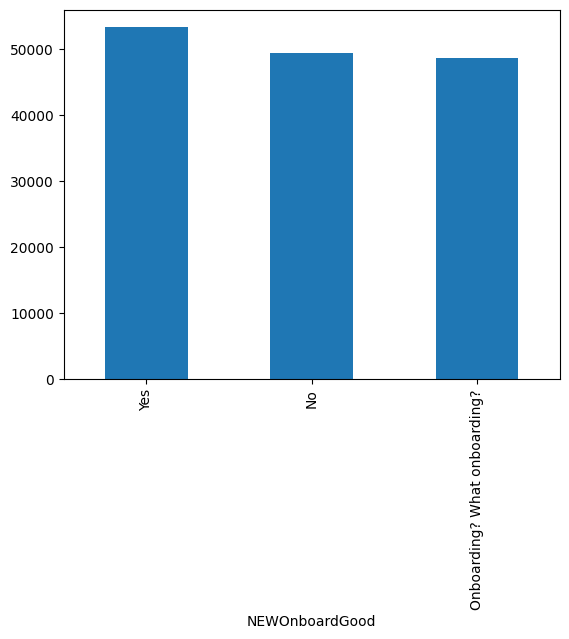

In [ ]:
# plot NEWOnboardGood by median salary
df.groupby(["NEWOnboardGood"])["Salary"].median().sort_values(ascending=False).plot(kind="bar")

In [ ]:
# map new onboarding to numerical values where 0 is "No" or "Onboarding? What onboarding?" and 1 is "Yes"
df["NEWOnboardGood"].replace({"No": 0,
                              "Onboarding? What onboarding?": 0,
                              "Yes": 1}, inplace=True)
df["NEWOnboardGood"] = df["NEWOnboardGood"].astype("float")

In [ ]:
# for each country, show the number of developers
df["Country"].value_counts()

United States                                6692
India                                        2470
United Kingdom                               2071
Germany                                      2005
Canada                                       1169
Brazil                                       1042
France                                        989
Poland                                        737
Netherlands                                   721
Spain                                         647
Australia                                     633
Italy                                         566
Russian Federation                            552
Sweden                                        528
Turkey                                        358
Pakistan                                      315
Israel                                        308
Switzerland                                   305
Mexico                                        281
Romania                                       279


#### Exploring education importance
The question asked was: "How important is a formal education, such as a university degree in computer science, to your career?". The feature unfortunately did not improve the model.

In [ ]:
# NEWEdImpt
df["NEWEdImpt"].value_counts()

Fairly important                      8121
Somewhat important                    7476
Very important                        6763
Not at all important/not necessary    4862
Critically important                  2406
Name: NEWEdImpt, dtype: int64

<AxesSubplot:xlabel='NEWEdImpt'>

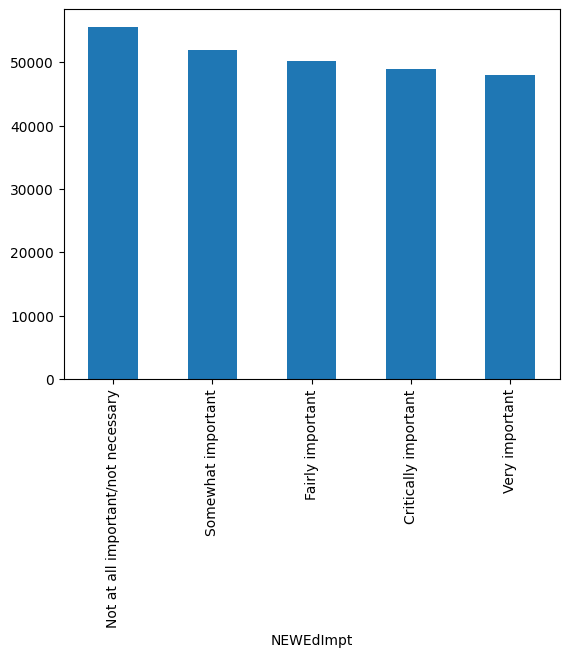

In [ ]:
# plot NEWEdImpt by median salary
df.groupby(["NEWEdImpt"])["Salary"].median().sort_values(ascending=False).plot(kind="bar")

#### Exploring undergrad major
The question asked was: "What was your primary field of study?". The feature unfortunately did not improve the model, despite me thinking otherwise, although it is evident once we look at the median salary for each undegrad and seeing computer science so low in the list.

In [ ]:
# UndergradMajor
df["UndergradMajor"].value_counts()

Computer science, computer engineering, or software engineering                   18174
Another engineering discipline (such as civil, electrical, mechanical, etc.)       2348
Information systems, information technology, or system administration              2135
A natural science (such as biology, chemistry, physics, etc.)                      1114
Mathematics or statistics                                                           920
Web development or web design                                                       879
A business discipline (such as accounting, finance, marketing, etc.)                630
A humanities discipline (such as literature, history, philosophy, etc.)             579
A social science (such as anthropology, psychology, political science, etc.)        454
Fine arts or performing arts (such as graphic design, music, studio art, etc.)      402
I never declared a major                                                            195
A health science (such as nursin

<AxesSubplot:xlabel='UndergradMajor'>

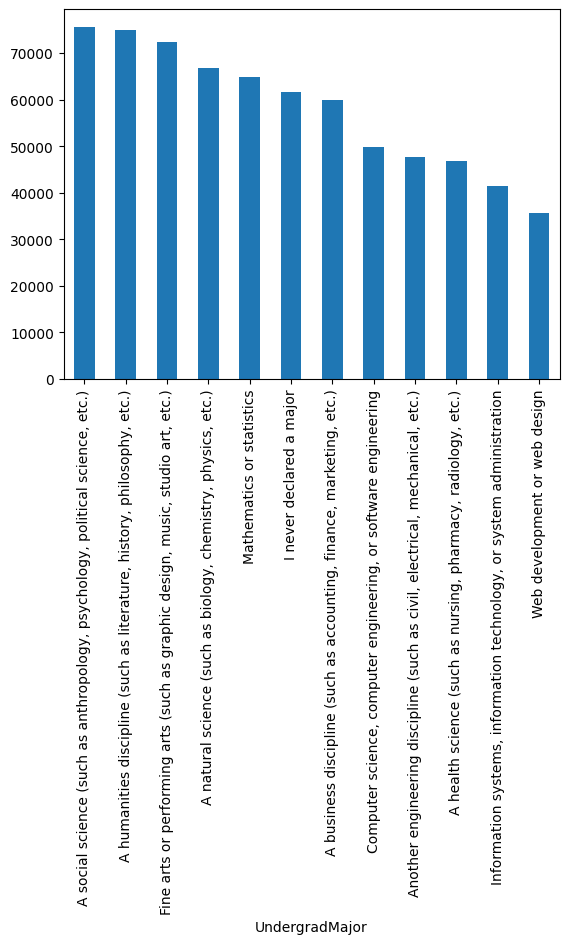

In [ ]:
# plot UndergradMajor by median salary
df.groupby(["UndergradMajor"])["Salary"].median().sort_values(ascending=False).plot(kind="bar")

### Exploring countries

In [ ]:
# for each country, show the median salary, ordered by median salary
df.groupby(["Country"])["Salary"].median().sort_values(ascending=False)

Country
United States                                110000.0
Israel                                        98064.0
Switzerland                                   96566.0
Andorra                                       88640.0
Bahamas                                       86706.0
Iceland                                       81840.0
Denmark                                       79896.0
Luxembourg                                    75669.0
Norway                                        75527.0
Australia                                     73491.0
Nomadic                                       70500.0
Lao People's Democratic Republic              69927.0
Ireland                                       67021.0
Canada                                        65043.0
United Kingdom                                64630.0
Hong Kong (S.A.R.)                            64580.0
New Zealand                                   63251.0
Germany                                       61616.0
Finland             

<AxesSubplot:xlabel='Country'>

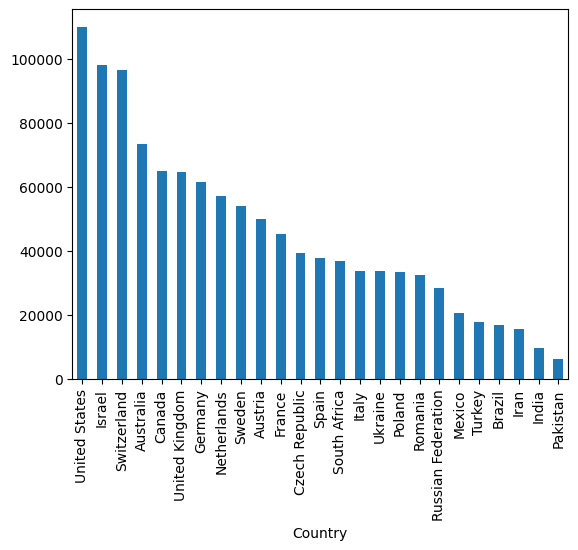

In [ ]:
# plot the median salary by country for countries with more than 250 developers, sorted by median salary
df.groupby(["Country"])["Salary"].median().loc[df["Country"].value_counts() > 250]\
    .sort_values(ascending=False).plot(kind="bar")

Here, I show a map of the world as a heatmap with the number of developers in each country. This visualization helps us see which countries have the most developers, and which have the least. We can see that the US has the most developers, followed by India, Germany, the UK and France. We can also see that there are many countries with very few developers, such as the countries in Africa.

In [ ]:
import pycountry
import plotly.express as px

# clone the dataframe
df2 = df.copy()

# get the country codes for each country
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

# add the country codes to the dataframe
df2["country_code"] = df2["Country"].map(countries.get)
# for each country, add the number of developers
df2["Country"] = df2["Country"].map(df2["Country"].value_counts())
# plot the map, using the country codes and the number of developers, but use a logarithmic scale
fig = px.choropleth(df2, locations="country_code",
                    color="Country",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Number of developers per country",
                    projection="natural earth",
                    range_color=[1, 3000],
                    )
fig.show()

In order for the data to be better utilised by the model, the categories will be shortened, and other smaller countries will all be placed in a separate category called "Other".

In [ ]:
country_map = shorten_categories(df["Country"].value_counts(), 100)
df["Country"] = df["Country"].map(country_map)
df.shape

(30057, 29)

#### Exploring developer types
The developer type has the possibility of having a great impact on our model. However, the data is in that ugly format where each developer can have multiple types. We will have to split the data into multiple columns, one for each type, and then we will be able to use it. Since the form also provided write-in, I only included the ones which have at least a certain number of developers in order to avoid feature explosion.

In [ ]:
df["DevType"].head(50)

7      Developer, back-end;Developer, desktop or ente...
9      Database administrator;Developer, full-stack;D...
10     Developer, back-end;Developer, desktop or ente...
11                         Designer;Developer, front-end
13     Developer, desktop or enterprise applications;...
15     Database administrator;Developer, back-end;Dev...
16                                 Developer, full-stack
18                                 Developer, full-stack
23                                   Developer, back-end
25                                 Developer, full-stack
29     Data or business analyst;Database administrato...
31     Developer, back-end;Developer, desktop or ente...
32     Developer, front-end;Developer, full-stack;Dev...
37             Developer, full-stack;Engineering manager
40     Developer, back-end;Developer, front-end;Devel...
41     Developer, back-end;Developer, desktop or ente...
42     Developer, back-end;Developer, front-end;Devel...
43     Data or business analyst

In [ ]:
 # DevType
dev_type = split_multicolumn(df["DevType"],"DEV_")
dev_type

DEV_Developer, back-end  \
7                          1.0   
9                          0.0   
10                         1.0   
11                         0.0   
13                         0.0   
...                        ...   
64141                      1.0   
64148                      0.0   
64152                      1.0   
64153                      0.0   
64154                      0.0   

       DEV_Developer, desktop or enterprise applications  \
7                                                    1.0   
9                                                    0.0   
10                                                   1.0   
11                                                   0.0   
13                                                   1.0   
...                                                  ...   
64141                                                1.0   
64148                                                0.0   
64152                                                0.0   
64153                                                0.0   
64154                                                0.0   

       DEV_Developer, game or graphics  DEV_Database administrator  \
7                                  1.0                         0.0   
9                                  0.0                         1.0   
10                                 0.0                         0.0   
11                                 0.0                         0.0   
13                                 0.0                         0.0   
...                                ...                         ...   
64141                              0.0                         1.0   
64148                              0.0                         0.0   
64152                              0.0                         0.0   
64153                              0.0                         0.0   
64154                              0.0                         0.0   

       DEV_Developer, full-stack  DEV_Developer, mobile  \
7                            0.0                    0.0   
9                            1.0                    1.0   
10                           0.0                    0.0   
11                           0.0                    0.0   
13                           0.0                    0.0   
...                          ...                    ...   
64141                        1.0                    1.0   
64148                        0.0                    0.0   
64152                        1.0                    0.0   
64153                        1.0                    0.0   
64154                        0.0                    0.0   

       DEV_Developer, embedded applications or devices  \
7                                                  0.0   
9                                                  0.0   
10                                                 1.0   
11                                                 0.0   
13                                                 0.0   
...                                                ...   
64141                                              0.0   
64148                                              0.0   
64152                                              0.0   
64153                                              0.0   
64154                                              0.0   

       DEV_Developer, front-end  DEV_Designer  DEV_Developer, QA or test  ...  \
7                           0.0           0.0                        0.0  ...   
9                           0.0           0.0                        0.0  ...   
10                          1.0           0.0                        0.0  ...   
11                          1.0           1.0                        0.0  ...   
13                          1.0           0.0                        0.0  ...   
...                         ...           ...                        ...  ...   
64141                       1.0           0.0                  

In [ ]:
def keep_columns(col, threshold):
    """
    This function keeps the columns of a dataframe that have a number of values above a threshold
    :param df: the dataframe
    :param col: the column to be checked
    :param threshold: the threshold
    :return: the columns to be kept
    """
    col_sum = col.sum().sort_values(ascending=False)
    keep_col = col_sum[col_sum.values >= threshold].index
    return keep_col

Here, I keep only the columns that have at least 1000 developers.

In [ ]:
keep_col = keep_columns(dev_type, 1000)
dev_type = dev_type[keep_col]
# concatenate the new columns to the dataframe
df = pd.concat([df, dev_type], axis=1)
# drop the original column
df.drop(["DevType"], axis=1, inplace=True)

In [ ]:
df.head()

Hobbyist   Age  Age1stCode    Salary         Country  \
7          1  36.0        12.0  116000.0   United States   
9          1  22.0        14.0   32315.0  United Kingdom   
10         1  23.0        13.0   40070.0  United Kingdom   
11         0  49.0        42.0   14268.0           Spain   
13         1  27.0        13.0   66000.0   United States   

                    DatabaseWorkedWith                   EdLevel  \
7                  MariaDB;MySQL;Redis         Bachelor's Degree   
9                 Microsoft SQL Server           Master's Degree   
10  Firebase;MongoDB;PostgreSQL;SQLite         Bachelor's Degree   
11                                 NaN  Some College, No diploma   
13       Firebase;Microsoft SQL Server          Associate Degree   

            Employment                                         JobFactors  \
7   Employed full-time  Remote work options;Opportunities for professi...   
9   Employed full-time  Flex time or a flexible schedule;How widely us...   
10  Employed full-time  Flex time or a flexible schedule;Languages, fr...   
11  Employed full-time  Remote work options;Office environment or comp...   
13  Employed full-time  Industry that I’d be working in;Flex time or a...   

    JobSat  ...  DEV_Developer, QA or test DEV_Engineer, data  \
7      0.0  ...                        0.0                0.0   
9      1.0  ...                        0.0                0.0   
10     0.0  ...                        0.0                0.0   
11     0.0  ...                        0.0                0.0   
13     0.0  ...                        0.0                0.0   

   DEV_Data scientist or machine learning specialist  \
7                                                0.0   
9                                                0.0   
10                                               0.0   
11                                               0.0   
13                                               0.0   

   DEV_Data or business analyst  DEV_Developer, game or graphics  \
7                           0.0                              1.0   
9                           0.0                              0.0   
10                          0.0                              0.0   
11                          0.0                              0.0   
13                          0.0                              0.0   

   DEV_Engineering manager DEV_Academic researcher DEV_Educator  \
7                      0.0                     0.0          0.0   
9                      0.0                     0.0          0.0   
10                     0.0                     0.0          0.0   
11                     0.0                     0.0          0.0   
13                     0.0                     0.0          0.0   

    DEV_Product manager DEV_Engineer, site reliability  
7                   0.0                            0.0  
9                   0.0                            0.0  
10                  0.0                            0.0  
11                  0.0                            0.0  
13                  0.0                            0.0  

[5 rows x 48 columns]

In [ ]:
dev_type

DEV_Developer, full-stack  DEV_Developer, back-end  \
7                            0.0                      1.0   
9                            1.0                      0.0   
10                           0.0                      1.0   
11                           0.0                      0.0   
13                           0.0                      0.0   
...                          ...                      ...   
64141                        1.0                      1.0   
64148                        0.0                      0.0   
64152                        1.0                      1.0   
64153                        1.0                      0.0   
64154                        0.0                      0.0   

       DEV_Developer, front-end  \
7                           0.0   
9                           0.0   
10                          1.0   
11                          1.0   
13                          1.0   
...                         ...   
64141                       1.0   
64148                       0.0   
64152                       1.0   
64153                       0.0   
64154                       1.0   

       DEV_Developer, desktop or enterprise applications  \
7                                                    1.0   
9                                                    0.0   
10                                                   1.0   
11                                                   0.0   
13                                                   1.0   
...                                                  ...   
64141                                                1.0   
64148                                                0.0   
64152                                                0.0   
64153                                                0.0   
64154                                                0.0   

       DEV_Developer, mobile  DEV_DevOps specialist  \
7                        0.0                    0.0   
9                        1.0                    0.0   
10                       0.0                    0.0   
11                       0.0                    0.0   
13                       0.0                    0.0   
...                      ...                    ...   
64141                    1.0                    1.0   
64148                    0.0                    0.0   
64152                    0.0                    0.0   
64153                    0.0                    0.0   
64154                    0.0                    0.0   

       DEV_Database administrator  \
7                             0.0   
9                             1.0   
10                            0.0   
11                            0.0   
13                            0.0   
...                           ...   
64141                         1.0   
64148                         0.0   
64152                         0.0   
64153                         0.0   
64154                         0.0   

       DEV_Developer, embedded applications or devices  \
7                                                  0.0   
9                                                  0.0   
10                                                 1.0   
11                                                 0.0   
13                                                 0.0   
...                                                ...   
64141                                              0.0   
64148                                              0.0   
64152                                              0.0   
64153                                              0.0   
64154                                              0.0   

       DEV_System administrator  DEV_Designer  DEV_Developer, QA or test  \
7                           0.0           0.0                        0.0   
9                           0.0           0.0                        0.0   
10                          0.0           0.0                        0.0   
11                       

#### Exploring languages
Similar to above, only this time we are dealing with programming languages.

In [ ]:
language = split_multicolumn(df["LanguageWorkedWith"], "LANG_")
keep_col = keep_columns(language, 500)
language = language[keep_col]
df = pd.concat([df, language], axis=1)
df.drop(["LanguageWorkedWith"], axis=1, inplace=True)

In [ ]:
language

LANG_JavaScript  LANG_HTML/CSS  LANG_SQL  LANG_Python  LANG_Java  \
7                  0.0            0.0       1.0          1.0        0.0   
9                  1.0            1.0       1.0          1.0        1.0   
10                 1.0            0.0       0.0          0.0        0.0   
11                 1.0            1.0       0.0          0.0        0.0   
13                 1.0            1.0       1.0          0.0        0.0   
...                ...            ...       ...          ...        ...   
64141              0.0            0.0       0.0          0.0        0.0   
64148              0.0            0.0       0.0          0.0        0.0   
64152              0.0            0.0       0.0          0.0        0.0   
64153              0.0            0.0       0.0          0.0        0.0   
64154              0.0            0.0       0.0          0.0        0.0   

       LANG_Bash/Shell/PowerShell  LANG_C#  LANG_TypeScript  LANG_PHP  \
7                             0.0      0.0              0.0       0.0   
9                             0.0      0.0              0.0       0.0   
10                            0.0      1.0              0.0       0.0   
11                            0.0      0.0              0.0       0.0   
13                            0.0      0.0              1.0       0.0   
...                           ...      ...              ...       ...   
64141                         0.0      0.0              0.0       0.0   
64148                         0.0      0.0              0.0       0.0   
64152                         0.0      0.0              0.0       0.0   
64153                         0.0      0.0              0.0       0.0   
64154                         0.0      0.0              0.0       0.0   

       LANG_C++  ...  LANG_Ruby  LANG_Swift  LANG_VBA  LANG_Rust  \
7           0.0  ...        0.0         0.0       0.0        0.0   
9           0.0  ...        0.0         0.0       0.0        0.0   
10          0.0  ...        0.0         1.0       0.0        0.0   
11          0.0  ...        0.0         0.0       0.0        0.0   
13          0.0  ...        0.0         0.0       0.0        0.0   
...         ...  ...        ...         ...       ...        ...   
64141       0.0  ...        0.0         0.0       0.0        0.0   
64148       0.0  ...        0.0         0.0       0.0        0.0   
64152       0.0  ...        0.0         0.0       0.0        0.0   
64153       0.0  ...        0.0         0.0       0.0        0.0   
64154       0.0  ...        0.0         0.0       0.0        0.0   

       LANG_Objective-C  LANG_Scala  LANG_R  LANG_Assembly  LANG_Dart  \
7                   0.0         0.0     0.0            0.0        0.0   
9                   0.0         0.0     0.0            0.0        0.0   
10                  0.0         0.0     0.0            0.0        0.0   
11                  0.0         0.0     0.0            0.0        0.0   
13                  0.0         0.0     0.0            0.0        0.0   
...                 ...         ...     ...            ...        ...   
64141               0.0         0.0     0.0            0.0        0.0   
64148               0.0         0.0     0.0            0.0        0.0   
64152               0.0         0.0     0.0            0.0        0.0   
64153               0.0         0.0     0.0            0.0        0.0   
64154               0.0         0.0     0.0            0.0        0.0   

       LANG_Perl  
7            0.0  
9            0.0  
10           0.0  
11           0.0  
13           0.0  
...          ...  
64141        0.0  
64148        0.0  
64152        0.0  
64153        0.0  
64154        0.0  

[30057 rows x 23 columns]

#### Exploring platforms
Similar to above, only this time we are dealing with platforms.

In [ ]:
# PlatformWorkedWith
platform = split_multicolumn(df["PlatformWorkedWith"], "PLAT_")
keep_col = keep_columns(platform, 500)
platform = platform[keep_col]
df = pd.concat([df, platform], axis=1)
df.drop(["PlatformWorkedWith"], axis=1, inplace=True)

In [ ]:
platform

PLAT_Linux  PLAT_Windows  PLAT_Docker  PLAT_AWS  PLAT_MacOS  \
7             0.0           0.0          1.0       0.0         0.0   
9             1.0           1.0          0.0       0.0         0.0   
10            0.0           0.0          0.0       1.0         0.0   
11            0.0           1.0          0.0       0.0         0.0   
13            0.0           1.0          0.0       0.0         0.0   
...           ...           ...          ...       ...         ...   
64141         0.0           0.0          0.0       0.0         0.0   
64148         0.0           0.0          0.0       0.0         0.0   
64152         1.0           0.0          1.0       0.0         1.0   
64153         0.0           0.0          0.0       0.0         0.0   
64154         0.0           0.0          0.0       0.0         0.0   

       PLAT_Android  PLAT_Microsoft Azure  PLAT_Google Cloud Platform  \
7               0.0                   0.0                         0.0   
9               1.0                   0.0                         0.0   
10              0.0                   0.0                         0.0   
11              0.0                   0.0                         0.0   
13              0.0                   0.0                         1.0   
...             ...                   ...                         ...   
64141           0.0                   0.0                         0.0   
64148           0.0                   0.0                         0.0   
64152           0.0                   0.0                         0.0   
64153           0.0                   0.0                         0.0   
64154           0.0                   0.0                         0.0   

       PLAT_Kubernetes  PLAT_Raspberry Pi  PLAT_WordPress  PLAT_iOS  \
7                  0.0                0.0             0.0       0.0   
9                  0.0                1.0             0.0       0.0   
10                 0.0                0.0             0.0       1.0   
11                 0.0                0.0             1.0       0.0   
13                 0.0                0.0             0.0       0.0   
...                ...                ...             ...       ...   
64141              0.0                0.0             0.0       0.0   
64148              0.0                0.0             0.0       0.0   
64152              0.0                0.0             0.0       0.0   
64153              0.0                0.0             0.0       0.0   
64154              0.0                0.0             0.0       0.0   

       PLAT_Heroku  PLAT_Slack Apps and Integrations  PLAT_Arduino  
7              0.0                               0.0           0.0  
9              0.0                               0.0           0.0  
10             1.0                               0.0           0.0  
11             0.0                               0.0           0.0  
13             0.0                               0.0           0.0  
...            ...                               ...           ...  
64141          0.0                               0.0           0.0  
64148          0.0                               0.0           0.0  
64152          0.0                               0.0           0.0  
64153          0.0                               0.0           0.0  
64154          0.0                               0.0           0.0  

[30057 rows x 15 columns]

#### Exploring databases

In [ ]:
# DatabaseWorkedWith
database = split_multicolumn(df["DatabaseWorkedWith"], "DB_")
keep_col = keep_columns(database, 500)
database = database[keep_col]
df = pd.concat([df, database], axis=1)
df.drop(["DatabaseWorkedWith"], axis=1, inplace=True)

In [ ]:
database

DB_MySQL  DB_PostgreSQL  DB_Microsoft SQL Server  DB_SQLite  \
7           1.0            0.0                      0.0        0.0   
9           0.0            0.0                      1.0        0.0   
10          0.0            1.0                      0.0        1.0   
11          0.0            0.0                      0.0        0.0   
13          0.0            0.0                      1.0        0.0   
...         ...            ...                      ...        ...   
64141       0.0            0.0                      0.0        0.0   
64148       0.0            0.0                      0.0        0.0   
64152       0.0            1.0                      0.0        0.0   
64153       0.0            0.0                      0.0        0.0   
64154       0.0            0.0                      0.0        0.0   

       DB_MongoDB  DB_Redis  DB_Elasticsearch  DB_MariaDB  DB_Oracle  \
7             0.0       1.0               0.0         1.0        0.0   
9             0.0       0.0               0.0         0.0        0.0   
10            1.0       0.0               0.0         0.0        0.0   
11            0.0       0.0               0.0         0.0        0.0   
13            0.0       0.0               0.0         0.0        0.0   
...           ...       ...               ...         ...        ...   
64141         0.0       0.0               0.0         0.0        0.0   
64148         0.0       0.0               0.0         0.0        0.0   
64152         0.0       0.0               0.0         0.0        0.0   
64153         0.0       0.0               0.0         0.0        0.0   
64154         0.0       0.0               0.0         0.0        0.0   

       DB_Firebase  DB_DynamoDB  DB_Cassandra  DB_IBM DB2  DB_Couchbase  
7              0.0          0.0           0.0         0.0           0.0  
9              0.0          0.0           0.0         0.0           0.0  
10             1.0          0.0           0.0         0.0           0.0  
11             0.0          0.0           0.0         0.0           0.0  
13             1.0          0.0           0.0         0.0           0.0  
...            ...          ...           ...         ...           ...  
64141          0.0          0.0           0.0         0.0           0.0  
64148          0.0          0.0           0.0         0.0           0.0  
64152          0.0          0.0           0.0         0.0           0.0  
64153          0.0          0.0           0.0         0.0           0.0  
64154          0.0          0.0           0.0         0.0           0.0  

[30057 rows x 14 columns]

#### Exploring platforms

In [ ]:
# WebframeWorkedWith
webframe = split_multicolumn(df["WebframeWorkedWith"], "WEB_")
keep_col = keep_columns(webframe, 500)
webframe = webframe[keep_col]
df = pd.concat([df, webframe], axis=1)
df.drop(["WebframeWorkedWith"], axis=1, inplace=True)

In [ ]:
webframe

WEB_jQuery  WEB_React.js  WEB_Angular  WEB_ASP.NET  WEB_ASP.NET Core  \
7             0.0           0.0          0.0          0.0               0.0   
9             1.0           0.0          0.0          0.0               0.0   
10            0.0           1.0          1.0          0.0               0.0   
11            1.0           0.0          0.0          1.0               0.0   
13            0.0           0.0          1.0          0.0               0.0   
...           ...           ...          ...          ...               ...   
64141         0.0           0.0          0.0          0.0               0.0   
64148         0.0           0.0          0.0          0.0               0.0   
64152         0.0           1.0          0.0          0.0               0.0   
64153         0.0           0.0          0.0          0.0               0.0   
64154         0.0           0.0          0.0          0.0               0.0   

       WEB_Express  WEB_Vue.js  WEB_Spring  WEB_Angular.js  WEB_Flask  \
7              0.0         0.0         0.0             0.0        1.0   
9              0.0         0.0         0.0             0.0        1.0   
10             0.0         0.0         0.0             1.0        0.0   
11             0.0         0.0         0.0             0.0        0.0   
13             0.0         1.0         0.0             0.0        0.0   
...            ...         ...         ...             ...        ...   
64141          0.0         0.0         0.0             0.0        0.0   
64148          0.0         0.0         0.0             0.0        0.0   
64152          0.0         0.0         0.0             0.0        0.0   
64153          0.0         0.0         0.0             0.0        0.0   
64154          0.0         0.0         0.0             0.0        0.0   

       WEB_Django  WEB_Laravel  WEB_Ruby on Rails  WEB_Symfony  WEB_Gatsby  \
7             0.0          0.0                0.0          0.0         0.0   
9             0.0          0.0                0.0          0.0         0.0   
10            1.0          0.0                0.0          0.0         0.0   
11            0.0          0.0                0.0          0.0         0.0   
13            0.0          0.0                0.0          0.0         0.0   
...           ...          ...                ...          ...         ...   
64141         0.0          0.0                0.0          0.0         0.0   
64148         0.0          0.0                0.0          0.0         0.0   
64152         0.0          0.0                0.0          0.0         0.0   
64153         0.0          0.0                0.0          0.0         0.0   
64154         0.0          0.0                0.0          0.0         0.0   

       WEB_Drupal  
7             0.0  
9             0.0  
10            0.0  
11            0.0  
13            0.0  
...           ...  
64141         0.0  
64148         0.0  
64152         0.0  
64153         0.0  
64154         0.0  

[30057 rows x 16 columns]

#### Exploring miscellaneous tech

In [ ]:
# MiscTechWorkedWith
misctech = split_multicolumn(df["MiscTechWorkedWith"], "MISC_")
keep_col = keep_columns(misctech, 500)
misctech = misctech[keep_col]
df = pd.concat([df, misctech], axis=1)
df.drop(["MiscTechWorkedWith"], axis=1, inplace=True)

In [ ]:
misctech

MISC_Node.js  MISC_.NET  MISC_.NET Core  MISC_Pandas  \
7               0.0        0.0             0.0          0.0   
9               0.0        0.0             0.0          1.0   
10              1.0        0.0             0.0          0.0   
11              0.0        1.0             0.0          0.0   
13              1.0        0.0             0.0          0.0   
...             ...        ...             ...          ...   
64141           0.0        0.0             0.0          0.0   
64148           0.0        0.0             0.0          0.0   
64152           0.0        0.0             0.0          0.0   
64153           0.0        0.0             0.0          0.0   
64154           0.0        0.0             0.0          0.0   

       MISC_React Native  MISC_TensorFlow  MISC_Unity 3D  MISC_Ansible  \
7                    0.0              0.0            0.0           1.0   
9                    0.0              0.0            0.0           0.0   
10                   0.0              0.0            0.0           0.0   
11                   0.0              0.0            0.0           0.0   
13                   0.0              0.0            0.0           0.0   
...                  ...              ...            ...           ...   
64141                0.0              0.0            0.0           0.0   
64148                0.0              0.0            0.0           0.0   
64152                0.0              0.0            0.0           0.0   
64153                0.0              0.0            0.0           0.0   
64154                0.0              0.0            0.0           0.0   

       MISC_Teraform  MISC_Cordova  MISC_Xamarin  MISC_Flutter  \
7                0.0           0.0           0.0           0.0   
9                0.0           0.0           0.0           0.0   
10               0.0           0.0           0.0           0.0   
11               0.0           0.0           0.0           0.0   
13               0.0           0.0           0.0           0.0   
...              ...           ...           ...           ...   
64141            0.0           0.0           0.0           0.0   
64148            0.0           0.0           0.0           0.0   
64152            0.0           0.0           0.0           0.0   
64153            0.0           0.0           0.0           0.0   
64154            0.0           0.0           0.0           0.0   

       MISC_Apache Spark  MISC_Keras  MISC_Hadoop  MISC_Torch/PyTorch  
7                    0.0         0.0          0.0                 0.0  
9                    0.0         0.0          0.0                 0.0  
10                   0.0         0.0          0.0                 0.0  
11                   0.0         0.0          0.0                 0.0  
13                   0.0         0.0          0.0                 0.0  
...                  ...         ...          ...                 ...  
64141                0.0         0.0          0.0                 0.0  
64148                0.0         0.0          0.0                 0.0  
64152                0.0         0.0          0.0                 0.0  
64153                0.0         0.0          0.0                 0.0  
64154                0.0         0.0          0.0                 0.0  

[30057 rows x 16 columns]

#### Exploring collaboration tools

In [ ]:
# NEWCollabToolsWorkedWith
collab = split_multicolumn(df["NEWCollabToolsWorkedWith"], "COLLAB_")
keep_col = keep_columns(collab, 500)
collab = collab[keep_col]
df = pd.concat([df, collab], axis=1)
df.drop(["NEWCollabToolsWorkedWith"], axis=1, inplace=True)

In [ ]:
collab

COLLAB_Github  COLLAB_Slack  COLLAB_Jira  \
7                1.0           1.0          1.0   
9                1.0           0.0          0.0   
10               1.0           1.0          1.0   
11               1.0           0.0          0.0   
13               1.0           0.0          1.0   
...              ...           ...          ...   
64141            0.0           0.0          0.0   
64148            0.0           0.0          0.0   
64152            1.0           1.0          1.0   
64153            0.0           0.0          0.0   
64154            0.0           0.0          0.0   

       COLLAB_Google Suite (Docs, Meet, etc)  COLLAB_Confluence  \
7                                        1.0                1.0   
9                                        0.0                0.0   
10                                       1.0                1.0   
11                                       0.0                0.0   
13                                       0.0                1.0   
...                                      ...                ...   
64141                                    0.0                0.0   
64148                                    0.0                0.0   
64152                                    0.0                1.0   
64153                                    0.0                0.0   
64154                                    0.0                0.0   

       COLLAB_Gitlab  COLLAB_Trello  COLLAB_Microsoft Teams  \
7                0.0            0.0                     1.0   
9                0.0            0.0                     1.0   
10               0.0            1.0                     1.0   
11               0.0            0.0                     0.0   
13               0.0            0.0                     1.0   
...              ...            ...                     ...   
64141            0.0            0.0                     0.0   
64148            0.0            0.0                     0.0   
64152            0.0            0.0                     0.0   
64153            0.0            0.0                     0.0   
64154            0.0            0.0                     0.0   

       COLLAB_Microsoft Azure  COLLAB_Stack Overflow for Teams  \
7                         0.0                              0.0   
9                         0.0                              0.0   
10                        1.0                              1.0   
11                        0.0                              0.0   
13                        0.0                              0.0   
...                       ...                              ...   
64141                     0.0                              0.0   
64148                     0.0                              0.0   
64152                     0.0                              0.0   
64153                     0.0                              0.0   
64154                     0.0                              0.0   

       COLLAB_Facebook Workplace  
7                            0.0  
9                            0.0  
10                           0.0  
11                           0.0  
13                           0.0  
...                          ...  
64141                        0.0  
64148                        0.0  
64152                        0.0  
64153                        0.0  
64154                        0.0  

[30057 rows x 11 columns]

#### Exploring job factors
These job factors are what the developers consider important when looking for a job, outside of compensation.

In [ ]:
# JobFactors
jobfactors = split_multicolumn(df["JobFactors"], "JOB_")
keep_col = keep_columns(jobfactors, 1000)
jobfactors = jobfactors[keep_col]
df = pd.concat([df, jobfactors], axis=1)
df.drop(["JobFactors"], axis=1, inplace=True)

In [ ]:
jobfactors

JOB_Languages, frameworks, and other technologies I’d be working with  \
7                                                    0.0                       
9                                                    0.0                       
10                                                   1.0                       
11                                                   0.0                       
13                                                   0.0                       
...                                                  ...                       
64141                                                0.0                       
64148                                                1.0                       
64152                                                1.0                       
64153                                                1.0                       
64154                                                0.0                       

       JOB_Flex time or a flexible schedule  \
7                                       0.0   
9                                       1.0   
10                                      1.0   
11                                      0.0   
13                                      1.0   
...                                     ...   
64141                                   0.0   
64148                                   0.0   
64152                                   1.0   
64153                                   0.0   
64154                                   0.0   

       JOB_Office environment or company culture  \
7                                            0.0   
9                                            0.0   
10                                           0.0   
11                                           1.0   
13                                           1.0   
...                                          ...   
64141                                        0.0   
64148                                        0.0   
64152                                        0.0   
64153                                        1.0   
64154                                        0.0   

       JOB_Opportunities for professional development  \
7                                                 1.0   
9                                                 1.0   
10                                                0.0   
11                                                0.0   
13                                                0.0   
...                                               ...   
64141                                             0.0   
64148                                             1.0   
64152                                             0.0   
64153                                             0.0   
64154                                             0.0   

       JOB_Remote work options  \
7                          1.0   
9                          0.0   
10                         1.0   
11                         1.0   
13                         0.0   
...                        ...   
64141                      0.0   
64148                      0.0   
64152                      1.0   
64153                      1.0   
64154                      0.0   

       JOB_How widely used or impactful my work output would be  \
7                                                    0.0          
9                                                    1.0          
10                                                   0.0          
11                                                   0.0          
13                                                   0.0          
...                                                  ...          
64141                                                0.0          
64148                                                0.0          
64152                                                0.0          
64153                                                0.0          
64154                    

#### Undergrad Major
Experimenting with this feature, I unfortunately only found reductions in RMSE and R2 scores when using it. I decided not to use it.

In [ ]:
# UndergradMajor

# undergrad = split_multicolumn(df["UndergradMajor"], "UNDER_")
# keep_col = keep_columns(undergrad, 100)
# undergrad = undergrad[keep_col]
# df = pd.concat([df, undergrad], axis=1)
# df.drop(["UndergradMajor"], axis=1, inplace=True)

In [ ]:
df.shape

(30057, 147)

### Correlation matrix
The correlation matrix shows linear relationships between the features. The closer the value is to 1, the stronger the relationship. The closer the value is to 0, the weaker the relationship. The closer the value is to -1, the stronger the inverse relationship. The correlation matrix is useful to see which features are more important to the model. Features that have a low correlation can be removed from the model in order to reduce the complexity of the model and to reduce the risk of overfitting the data.

In [ ]:
pd.options.display.max_rows = 200
corr_matrix = df.corr()
corr_matrix["Salary"].sort_values(ascending=False)

Salary                                                                        1.000000
YearsCodePro                                                                  0.400352
Age                                                                           0.383447
COLLAB_Confluence                                                             0.197104
LANG_Bash/Shell/PowerShell                                                    0.181575
OrgSize                                                                       0.177914
JobSeek                                                                       0.174359
PLAT_AWS                                                                      0.165188
DEV_Engineering manager                                                       0.148758
JobSat                                                                        0.148352
PLAT_Kubernetes                                                               0.146766
MISC_Teraform                              

Some visualizations of the correlation matrix using a scatter matrix.

array([[<AxesSubplot:xlabel='Salary', ylabel='Salary'>,
        <AxesSubplot:xlabel='YearsCodePro', ylabel='Salary'>,
        <AxesSubplot:xlabel='Age', ylabel='Salary'>],
       [<AxesSubplot:xlabel='Salary', ylabel='YearsCodePro'>,
        <AxesSubplot:xlabel='YearsCodePro', ylabel='YearsCodePro'>,
        <AxesSubplot:xlabel='Age', ylabel='YearsCodePro'>],
       [<AxesSubplot:xlabel='Salary', ylabel='Age'>,
        <AxesSubplot:xlabel='YearsCodePro', ylabel='Age'>,
        <AxesSubplot:xlabel='Age', ylabel='Age'>]], dtype=object)

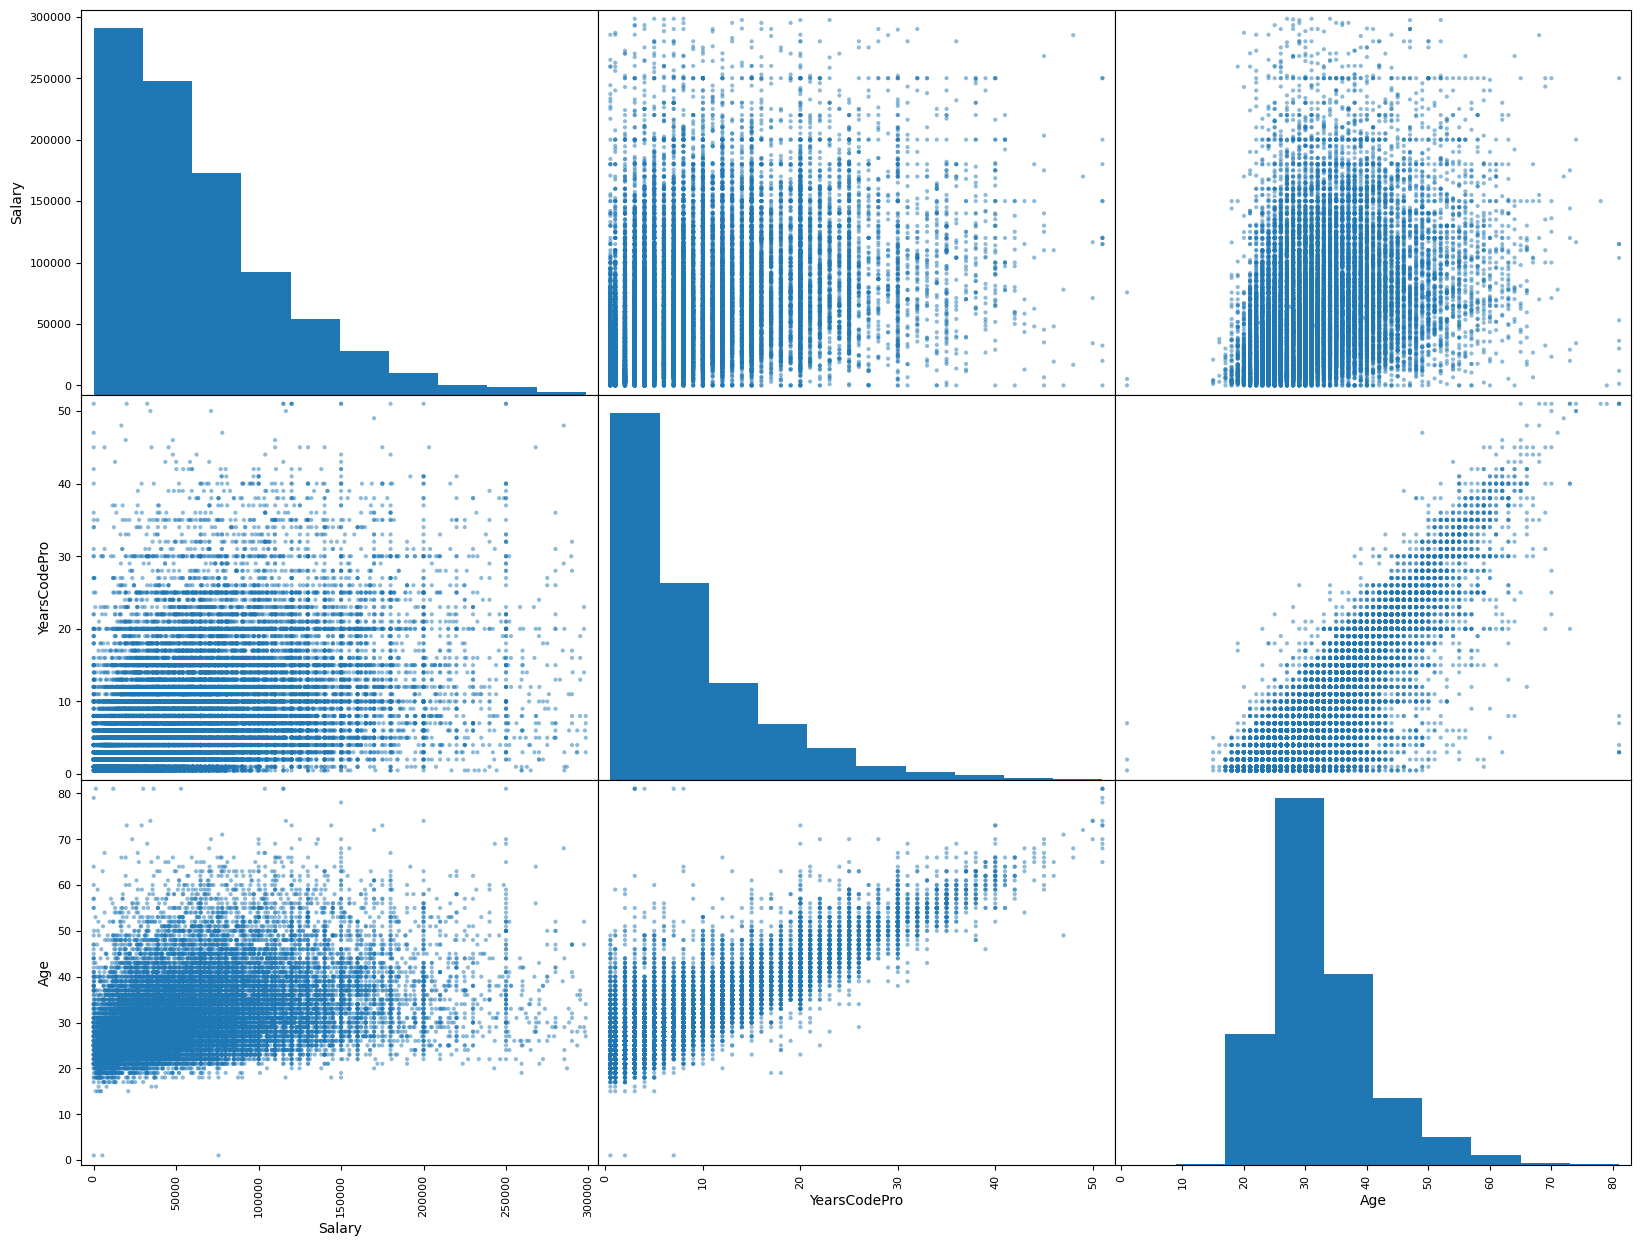

In [ ]:
attributes = ["Salary", "YearsCodePro", "Age"]
scatter_matrix(df[attributes], figsize=(20, 15))

#### Logarithm of the salary
During our lab discussion, you mentioned using the log of the salary to reduce the skewness of the data. I tried it out, and it did reduce the skewness of the data.

In the end, I decided not to use the logarithm of the salary because while predicting the logarithm had lower errors, when doing the reverse operation to the real size, the errors were higher. It was worth a shot though.

In [ ]:
# logarithm of the salary
#df["Salary"] = np.log(df["Salary"] + 1)

## Train-test split and feature selection
I considered the split features on columns alongside those in the "features1" list. After many trial and error, I ended up with this list. I provided some iterations of what I tried in the txt files, but the gist of it is that NOTHING is strongly correlated to the salary, and one can only hope to get a decent model by combining many features together. I tried this with the splitting of the columns, but there was only so much I could do.

In [ ]:
features1 = ["Salary","YearsCodePro","Age","JobSat","JobSeek","EdLevel", "Country","OrgSize","PurchaseWhat"]
features2=  list(dev_type.columns)+ list(language.columns)+ list(platform.columns) + list(database.columns) + list(webframe.columns) + list(misctech.columns) + list(collab.columns) + list(jobfactors.columns)

features = features1 + features2
num_attribs = ["YearsCodePro", "Age","JobSat","JobSeek", "OrgSize","PurchaseWhat"]

df3 = df[features].copy()
df3.dropna(inplace=True)


train, test = train_test_split(df3, test_size=0.2,random_state=42)

print("*" * 25)

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print("*" * 25)

X_train = train.drop(["Salary"], axis=1)
y_train = train["Salary"].values
X_test= test.drop(["Salary"], axis=1)
y_test = test["Salary"].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("*" * 25)

*************************
Train shape: (18623, 135)
Test shape: (4656, 135)
*************************
X_train shape: (18623, 134)
y_train shape: (18623,)
X_test shape: (4656, 134)
y_test shape: (4656,)
*************************


In [ ]:
scoring = ["neg_root_mean_squared_error",
            "neg_mean_absolute_error", "r2"]

For the transformation pipeline, I used a one-hot encoder for the categorical features, and a max absolute scaler for the numerical features. I tried using a standard scaler, but it did not improve the results. Also, I tried an ordinal encoder for EdLevel and Country but it made the model ever so slightly worse, but faster to train.

In [ ]:
transform = ColumnTransformer([
    #("label", OrdinalEncoder(), ["EdLevel", "Country"]),
    ("onehot", OneHotEncoder(sparse_output=False), ["EdLevel", "Country"]),
    ("scaler", MaxAbsScaler(), ["YearsCodePro","Age", "JobSeek", "JobSat","OrgSize"])
], remainder="passthrough")

#### Test function
The function takes in a model and trains it using cross validation. It then prints the RMSE, MAE and R2 scores. It uses K-FOLD with 5 splits.

In [ ]:
def test_model(model):
    pipe = Pipeline([
        ("preprocess", transform),
        ("model", model)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_validate(pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=4, error_score='raise')
    print(f"RMSE: mean: {-1 * np.mean(scores['test_neg_root_mean_squared_error'])} | {-1 * scores['test_neg_root_mean_squared_error']}")
    print(f"MAE: mean: {-1 * np.mean(scores['test_neg_mean_absolute_error'])} | {-1 * scores['test_neg_mean_absolute_error']}")
    print(f"R2-score: mean: {np.mean(scores['test_r2'])} | {scores['test_r2']}")
    print("*" * 25)
    print()

In [ ]:
scoring.errror_me()

AttributeError: 'list' object has no attribute 'errror_me'

### Decision tree regressor
A simple regressor, only used as a starting point. It is not very good, but it is fast to train.

In [ ]:
model = DecisionTreeRegressor(random_state=42, max_features=500)

test_model(model)

RMSE: mean: 42017.09603411514 | [42585.59232239 40353.3472238  43283.42912206 43128.62680267
 40734.48469966]
MAE: mean: 26214.111897418526 | [26086.95409396 25313.28483221 27036.23114094 26975.132116
 25658.95730397]
R2-score: mean: 0.272284418441102 | [0.25224398 0.29673611 0.23569652 0.26316683 0.31357865]
*************************



### AdaBoost
Adaboost helps you combine multiple “weak classifiers” into a single “strong classifier.”

In [ ]:
model = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=200, random_state=42)

test_model(model)

RMSE: mean: 28195.8850982331 | [28646.5365472  27297.3549594  28860.60389586 28925.36096036
 27249.56912835]
MAE: mean: 17327.516242129775 | [17469.55812081 16977.81234899 17478.20107383 17659.87164339
 17052.13802363]
R2-score: mean: 0.6722828374911549 | [0.66164019 0.67818942 0.6601922  0.6685672  0.69282518]
*************************



### Bagging

In [ ]:
model = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=200, n_jobs=4, random_state=42)

test_model(model)

RMSE: mean: 28462.759744064526 | [29086.4281404  27610.81210975 29013.85392176 29007.52300103
 27595.18154739]
MAE: mean: 18044.17083129139 | [18332.53766577 17794.96683893 18111.20184966 18381.39895542
 17600.74884667]
R2-score: mean: 0.6660328805812155 | [0.6511688  0.67075624 0.65657385 0.66668167 0.68498384]
*************************



### Random forest

In [ ]:
model = RandomForestRegressor(n_estimators=200, n_jobs=4, random_state=42)

test_model(model)

RMSE: mean: 28463.69784844589 | [29067.7102501  27610.06207346 29011.06610555 29010.57803656
 27619.07277656]
MAE: mean: 18052.542204637215 | [18328.08086174 17821.70030738 18121.96848591 18394.37896079
 17596.58240736]
R2-score: mean: 0.666016237584669 | [0.65161762 0.67077413 0.65663985 0.66661146 0.68443813]
*************************



### Gradient boosting

In [ ]:
model = GradientBoostingRegressor(n_estimators=200, random_state=42)

test_model(model)

RMSE: mean: 28099.37901073494 | [28505.44418508 27188.38563881 28613.26077364 28796.80374271
 27393.00071343]
MAE: mean: 17773.035256804927 | [17932.42822693 17426.55546697 17842.85483035 18161.08307056
 17502.25468922]
R2-score: mean: 0.6745600036908134 | [0.66496501 0.68075358 0.66599173 0.67150673 0.68958297]
*************************



### XGBoost

In [ ]:
model = XGBRegressor(n_estimators=200, n_jobs=4, random_state=42)

test_model(model)

RMSE: mean: 28914.544502848417 | [29349.23145118 28127.35643158 29425.52317552 29582.67542078
 28087.93603518]
MAE: mean: 18418.47023912421 | [18522.01519284 18146.69060936 18512.99310805 18796.70077643
 18113.95150895]
R2-score: mean: 0.6553767757986086 | [0.64483677 0.658322   0.64675916 0.65333276 0.67363319]
*************************



### LightGBM
This regressor deserves a special mention because of the library and the accuracy it consistently provides. It is also very fast to train, only 2 seconds compared to minutes for the other models. A true winner, and it also has nice visualizations.

In [ ]:
model =  lightgbm.sklearn.LGBMRegressor(n_estimators=200, n_jobs=4, random_state=42)

test_model(model)

RMSE: mean: 27437.04102136476 | [27709.38536609 26691.46729025 28023.37092815 28130.08522093
 26630.89630141]
MAE: mean: 17094.25759870943 | [17177.58205872 16884.38381705 17207.8536671  17408.37685454
 16793.09159614]
R2-score: mean: 0.6897022334671351 | [0.68341647 0.69231659 0.67962157 0.68654153 0.70661501]
*************************



## Hyperparameter tuning
For the LightGBM regressor, I used a grid search to find the best hyper parameters. I used the r2 score. Multiple learning rates and number of estimators were tried.

In [ ]:
model = lightgbm.sklearn.LGBMRegressor(n_jobs=4, random_state=42)

params = {
    "n_estimators": [80, 100, 150, 200],
     "learning_rate": [0.075, 0.1, 0.15],
    "loss": ['squared_error'],
}

grid = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, n_jobs=4, verbose=1, cv=5, refit="r2",
                    return_train_score=True)

pipe = Pipeline([
    ("preprocess", transform),
    ("grid", grid)
])

pipe.fit(X_train, y_train)
print(f"The best params: {pipe['grid'].best_params_}")
print(f"The best score: {pipe['grid'].best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
The best params: {'learning_rate': 0.075, 'loss': 'squared_error', 'n_estimators': 200}
The best score: 0.6921027789057148


Some visualization of the boosted trees in the result

In [ ]:
lightgbm.plot_tree(pipe["grid"].best_estimator_, figsize=(12, 8))

<AxesSubplot:>

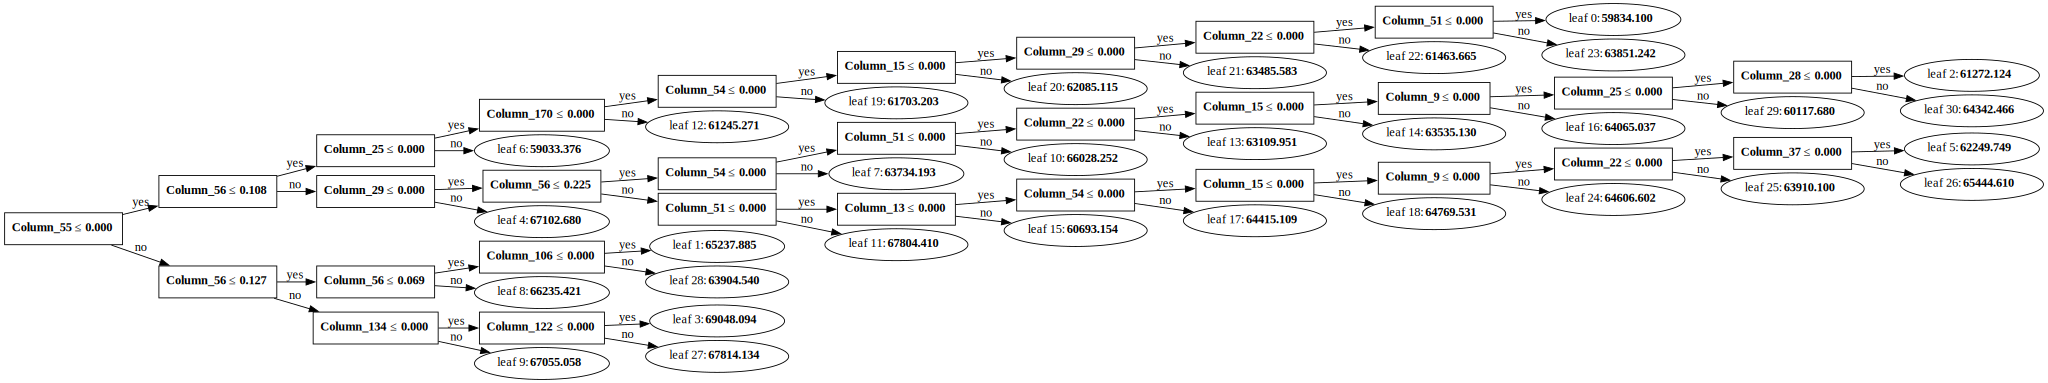

In [ ]:
lightgbm.create_tree_digraph(pipe["grid"].best_estimator_)

### Feature importance
Feature importance can be seen below. The most important features ended up being the age, years as a professional, being from the USA, working in a large organization and being satisfied with the job.

In [ ]:
feature_importances = grid.best_estimator_.feature_importances_
cat_encoder = pipe["preprocess"].named_transformers_["onehot"]
cat_one_hot_attribs1 = list(cat_encoder.categories_[0])
cat_one_hot_attribs2 = list(cat_encoder.categories_[1])
#cat_one_hot_attribs3 = list(cat_encoder.categories_[2])
attributes = cat_one_hot_attribs1 + cat_one_hot_attribs2 + num_attribs+ list(dev_type.columns) + list(language.columns)+ list(platform.columns) + list(database.columns) + list(webframe.columns) + list(misctech.columns) + list(collab.columns) + list(jobfactors)
sorted(zip(feature_importances, attributes), reverse=True)

[(446, 'YearsCodePro'),
 (380, 'Age'),
 (170, 'United States'),
 (141, 'OrgSize'),
 (113, 'JobSat'),
 (86, 'COLLAB_Confluence'),
 (83, 'United Kingdom'),
 (76, 'Israel'),
 (71, 'PLAT_Windows'),
 (70, 'Switzerland'),
 (67, 'LANG_C++'),
 (67, 'COLLAB_Jira'),
 (66, 'Germany'),
 (66, 'Canada'),
 (64, 'COLLAB_Gitlab'),
 (61, 'DEV_Engineering manager'),
 (60, 'COLLAB_Google Suite (Docs, Meet, etc)'),
 (57, 'COLLAB_Slack'),
 (57, 'Australia'),
 (54, 'PurchaseWhat'),
 (54, 'JOB_Office environment or company culture'),
 (52, 'LANG_PHP'),
 (51, 'JOB_Specific department or team I’d be working on'),
 (50, 'WEB_jQuery'),
 (49, 'PLAT_Kubernetes'),
 (48, 'PLAT_MacOS'),
 (48, 'PLAT_AWS'),
 (48, 'JobSeek'),
 (48, 'India'),
 (47, 'LANG_Bash/Shell/PowerShell'),
 (47, 'Denmark'),
 (46, 'JOB_Flex time or a flexible schedule'),
 (45, 'Norway'),
 (45, "Master's Degree"),
 (45, 'JOB_How widely used or impactful my work output would be'),
 (45, 'COLLAB_Microsoft Teams'),
 (42, 'JOB_Remote work options'),
 (42,

### Evaluation on the test set
The evaluate function takes in the true values and the predicted values and prints the RMSE, MAE and R2 scores.

In [ ]:
def evaluate(y_true, y_pred, to_e=False):
    if to_e:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)

    rmse = metrics.mean_squared_error(y_true=y_true, y_pred= y_pred, squared=False)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    metrics_dict = {
        "Metrics": ["Root Mean Square Error (RMSE)",
                    "Mean Absolute Error (MAE)",
                    "R2-score (R2)"],
        "Values": [rmse,
                    mae,
                    r2]
    }
    metrics_df = pd.DataFrame(metrics_dict)
    print(metrics_df)

The best values found are MAE of around 16k with a r2-score above 0.7. This is not ideal, but it's good enough given the data we have to work with.

In [ ]:
model = lightgbm.sklearn.LGBMRegressor(random_state=42,
                                learning_rate=0.075,
                                loss='squared_error',
                                n_estimators= 200)
pipe = Pipeline([
    ("preprocess", transform),
    ("model", model)
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
evaluate(y_test, y_pred, to_e=False)

                         Metrics        Values
0  Root Mean Square Error (RMSE)  26003.528906
1      Mean Absolute Error (MAE)  16476.095169
2                  R2-score (R2)      0.718558


### Save the model

In [ ]:
joblib.dump(pipe, "best_model_yet.joblib")

### Visualize the differences between the actual and predicted values

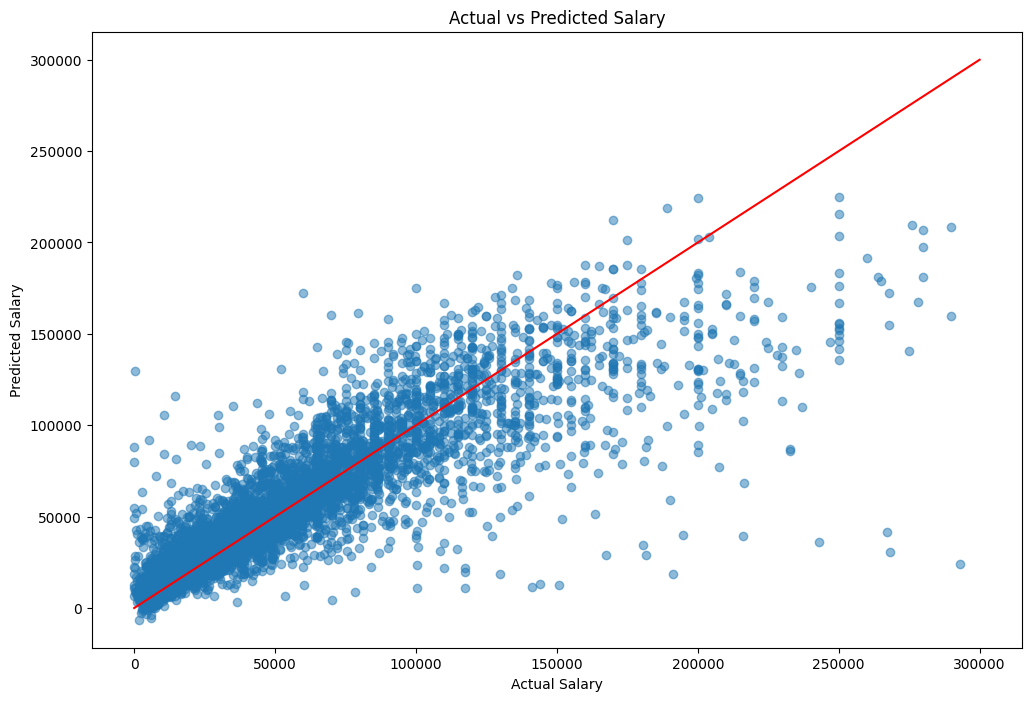

In [ ]:
# plot prediction vs actual value for salary
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
# plot a line, a perfect prediction would be a straight line
plt.plot(np.linspace(0, max_salary), np.linspace(0, max_salary), color="red")
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salary")
plt.show()

## Error analysis
During the final discussion, I was recommended to try to identify where those big RMSE errors come from. The way I did this was to create another dataframe with just the test set, and add the actual salary and predicted salary to it. Then I added a column for the error. I then filtered the dataframe to only show the rows where the error was greater than 50k. I then looked at the median salary of those rows, and it was 180k!! This means that the model is not very good at predicting high salaries. This is probably because there are not many high salaries in the dataset, so the model has not seen enough of them to learn how to predict them. This is a problem that could be solved by getting more data.

In [ ]:
# grab all the test cases where an error of at least error_cutoff was made
error_cutoff = 50000
# for each entry in the test set, grab it from the original dataframe
test_df = df.loc[X_test.index]

# add the actual salary and predicted salary to the dataframe
test_df["Actual Salary"] = y_test
test_df["Predicted Salary"] = y_pred

# add a column for the error
test_df["Error"] = test_df["Actual Salary"] - test_df["Predicted Salary"]

# show only the rows where the error is greater than 50k
df_big_error = test_df[test_df["Error"] > error_cutoff].copy()


In [ ]:
# median salary of df3
df_big_error["Actual Salary"].median()

181232.5

Yet I wanted to do more. The next thing I did was to look at the features of the rows where the error was greater than 50k. I did this by creating a new dataframe with the features of the rows where the error was greater than 50k. I then counted the number of times each feature appeared in the dataframe. I then divided this number by the number of rows in the dataframe to get the percentage of times each feature appeared. This is shown below.

In [ ]:
# make a new dataframe where each row is a collumn in df3 under "name"
df_percent = pd.DataFrame()
df_percent["name"] = df3.columns

# add a collumn called "percentage found"
df_percent["percentage found"] = 0.0

# count the number of times the feature appears in df3 and divide by the number of rows in df3
for i in range(len(df_percent)):
    # df4.loc[i, "percentage found"] = df3[df4.loc[i, "name"]].count()
    # only count if column is equal to 1.0
    df_percent.loc[i, "percentage found"] = df3[df3[df_percent.loc[i, "name"]] == 1.0][df_percent.loc[i, "name"]].count() / len(df3) * 100

df_percent.sort_values(by="percentage found", ascending=False)

name  percentage found
113                                      COLLAB_Github         77.769664
29                                     LANG_JavaScript         71.936080
30                                       LANG_HTML/CSS         62.704584
9                            DEV_Developer, full-stack         59.646033
10                             DEV_Developer, back-end         59.233644
114                                       COLLAB_Slack         59.053224
115                                        COLLAB_Jira         58.232742
31                                            LANG_SQL         57.678594
8                                         PurchaseWhat         56.282486
124  JOB_Languages, frameworks, and other technolog...         54.087375
52                                          PLAT_Linux         53.026333
53                                        PLAT_Windows         47.686756
126          JOB_Office environment or company culture         46.569870
125               JOB_Flex time or a flexible schedule         45.263972
67                                            DB_MySQL         44.056875
116              COLLAB_Google Suite (Docs, Meet, etc)         42.506121
54                                         PLAT_Docker         41.891834
117                                  COLLAB_Confluence         40.968255
127     JOB_Opportunities for professional development         39.967353
32                                         LANG_Python         39.915804
97                                        MISC_Node.js         39.829890
11                            DEV_Developer, front-end         38.111603
118                                      COLLAB_Gitlab         37.931183
33                                           LANG_Java         37.810903
34                          LANG_Bash/Shell/PowerShell         36.887323
68                                       DB_PostgreSQL         35.993814
35                                             LANG_C#         34.357146
81                                          WEB_jQuery         33.102797
128                            JOB_Remote work options         33.094205
3                                               JobSat         32.746252
69                             DB_Microsoft SQL Server         31.809786
36                                     LANG_TypeScript         31.758237
82                                        WEB_React.js         30.933459
55                                            PLAT_AWS         30.246145
119                                      COLLAB_Trello         30.121569
120                             COLLAB_Microsoft Teams         29.155032
98                                           MISC_.NET         27.793290
56                                          PLAT_MacOS         25.490786
70                                           DB_SQLite         25.168607
12   DEV_Developer, desktop or enterprise applications         24.717557
37                                            LANG_PHP         23.570600
71                                          DB_MongoDB         23.527643
99                                      MISC_.NET Core         22.427939
57                                        PLAT_Android         21.401263
83                                         WEB_Angular         21.379784
129  JOB_How widely used or impactful my work outpu...         20.370291
72                                            DB_Redis         20.189871
84                                         WEB_ASP.NET         19.064393
13                               DEV_Developer, mobile         18.411444
38                                            LANG_C++         18.243911
85                                    WEB_ASP.NET Core         17.509343
86                                         WEB_Express         17.114137
121                             COLLAB_Microsoft Azure         16.770480
58                                PLAT_Microsoft Azure         16.272177
39                                 

I also did the same for the other data

In [ ]:
# make a new dataframe where each row is a collumn in df3 under "name"
df_percent2 = pd.DataFrame()
df_percent2["name"] = df3.columns

df_big_copy = df.copy()
df_big_copy["Actual Salary"] = 0
df_big_copy["Predicted Salary"] = 0
df_big_copy["Error"] = 0
# add a collumn called "percentage found"
df_percent2["percentage found"] = 0.0

# count the number of times the feature appears in df3 and divide by the number of rows in df3
for i in range(len(df_percent2)):
    df_percent2.loc[i, "percentage found"] = df_big_copy[df_big_copy[df_percent2.loc[i, "name"]] == 1.0][df_percent2.loc[i, "name"]].count() / len(df_big_copy) * 100

df_percent2.sort_values(by="percentage found", ascending=False)

name  percentage found
113                                      COLLAB_Github         75.320225
29                                     LANG_JavaScript         70.216588
30                                       LANG_HTML/CSS         61.489836
9                            DEV_Developer, full-stack         60.245533
10                             DEV_Developer, back-end         59.553515
114                                       COLLAB_Slack         56.456067
31                                            LANG_SQL         56.123366
115                                        COLLAB_Jira         54.576305
124  JOB_Languages, frameworks, and other technolog...         52.034468
52                                          PLAT_Linux         51.462222
8                                         PurchaseWhat         48.947001
53                                        PLAT_Windows         46.305353
67                                            DB_MySQL         43.883288
125               JOB_Flex time or a flexible schedule         43.597165
126          JOB_Office environment or company culture         43.407526
116              COLLAB_Google Suite (Docs, Meet, etc)         40.815783
54                                         PLAT_Docker         39.837642
11                            DEV_Developer, front-end         38.949330
97                                        MISC_Node.js         38.626609
32                                         LANG_Python         38.164155
127     JOB_Opportunities for professional development         38.150847
117                                  COLLAB_Confluence         37.917956
118                                      COLLAB_Gitlab         36.713578
33                                           LANG_Java         36.527265
34                          LANG_Bash/Shell/PowerShell         35.083342
68                                       DB_PostgreSQL         34.996839
128                            JOB_Remote work options         34.055295
35                                             LANG_C#         33.153675
81                                          WEB_jQuery         32.914130
3                                               JobSat         32.578102
69                             DB_Microsoft SQL Server         30.678378
36                                     LANG_TypeScript         30.641781
82                                        WEB_React.js         29.720198
119                                      COLLAB_Trello         29.517251
55                                            PLAT_AWS         29.181222
120                             COLLAB_Microsoft Teams         27.194996
98                                           MISC_.NET         26.775793
70                                           DB_SQLite         25.295272
12   DEV_Developer, desktop or enterprise applications         25.252021
56                                          PLAT_MacOS         24.809529
37                                            LANG_PHP         24.210666
71                                          DB_MongoDB         23.079482
99                                      MISC_.NET Core         21.605616
57                                        PLAT_Android         21.572346
83                                         WEB_Angular         20.973484
72                                            DB_Redis         19.509598
13                               DEV_Developer, mobile         19.502944
129  JOB_How widely used or impactful my work outpu...         19.423096
84                                         WEB_ASP.NET         18.498187
38                                            LANG_C++         18.108926
85                                    WEB_ASP.NET Core         17.060918
86                                         WEB_Express         16.714908
121                             COLLAB_Microsoft Azure         16.106065
58                                PLAT_Microsoft Azure         15.763383
39                                 

Finally, by subtracting the percentages, we can clearly see which features are more common in the rows where the error is greater than 50k. Those include being involved in the purchase decisions and using some of the collaboration platforms, however even here the difference is not very big in percentage terms.

In [ ]:
# adding the percentage difference between the two dataframes
df_percent["difference"] = df_percent["percentage found"] - df_percent2["percentage found"]
# add a column of "positive" if the difference is positive, "negative" if the difference is negative
df_percent["positive/negative"] = np.where(df_percent["difference"] > 0, "positive", "negative")
# difference goes in abs
df_percent["difference"] = abs(df_percent["difference"])
# sort by difference
df_percent.sort_values(by="difference", ascending=False)

name  percentage found  \
8                                         PurchaseWhat         56.282486   
115                                        COLLAB_Jira         58.232742   
126          JOB_Office environment or company culture         46.569870   
117                                  COLLAB_Confluence         40.968255   
114                                       COLLAB_Slack         59.053224   
113                                      COLLAB_Github         77.769664   
54                                         PLAT_Docker         41.891834   
124  JOB_Languages, frameworks, and other technolog...         54.087375   
120                             COLLAB_Microsoft Teams         29.155032   
127     JOB_Opportunities for professional development         39.967353   
34                          LANG_Bash/Shell/PowerShell         36.887323   
32                                         LANG_Python         39.915804   
29                                     LANG_JavaScript         71.936080   
116              COLLAB_Google Suite (Docs, Meet, etc)         42.506121   
125               JOB_Flex time or a flexible schedule         45.263972   
52                                          PLAT_Linux         53.026333   
31                                            LANG_SQL         57.678594   
53                                        PLAT_Windows         47.686756   
33                                           LANG_Java         37.810903   
118                                      COLLAB_Gitlab         37.931183   
30                                       LANG_HTML/CSS         62.704584   
82                                        WEB_React.js         30.933459   
35                                             LANG_C#         34.357146   
97                                        MISC_Node.js         39.829890   
69                             DB_Microsoft SQL Server         31.809786   
36                                     LANG_TypeScript         31.758237   
13                               DEV_Developer, mobile         18.411444   
55                                            PLAT_AWS         30.246145   
7                                              OrgSize         14.132909   
98                                           MISC_.NET         27.793290   
68                                       DB_PostgreSQL         35.993814   
60                                     PLAT_Kubernetes         14.046995   
128                            JOB_Remote work options         33.094205   
129  JOB_How widely used or impactful my work outpu...         20.370291   
18                                        DEV_Designer          8.196228   
62                                      PLAT_WordPress         11.095837   
11                            DEV_Developer, front-end         38.111603   
99                                      MISC_.NET Core         22.427939   
73                                    DB_Elasticsearch         15.193952   
56                                          PLAT_MacOS         25.490786   
72                                            DB_Redis         20.189871   
15                          DEV_Database administrator         10.438593   
121                             COLLAB_Microsoft Azure         16.770480   
130                JOB_Industry that I’d be working in         14.107135   
88                                          WEB_Spring         14.626917   
37                                            LANG_PHP         23.570600   
133  JOB_Specific department or team I’d be working on         10.988445   
119                                      COLLAB_Trello         30.121569   
100                                        MISC_Pandas          9.506422   
9                            DEV_Developer, full-stack         59.646033   
90                                           WEB_Flask         10.434297   
84                                         WEB_ASP.NET         19.064393   
27                    

## Conclusion
In conclusion, I was able to create a model that can predict the salary of a data scientist with a MAE of around 16k and a r2-score of around 0.7. This is not ideal, but it's good enough given the data we have to work with.

There is still so much more work that can be done, like engineering some new features, or trying out new models or scaling patterns. I know that I have learned a lot from this project, and I am happy with the results and with the knowledge I have gained.